# Global setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import function as func
import os
import lmfit
import math
from scipy import integrate
from scipy import interpolate

In [2]:
# Distance between two (input and output) antennas at xy-scan measurement
AntennaDistance = 1085

# Simulation result of FWHM [deg.]
FWHM_simulation = np.array([21.2, 20.2, 19.2, 18.2, 17.4, 16.6, 15.8, 15.2, 14.8])

In [3]:
# Container for each frequency fit-result
fit_result = {
    "18": {}, 
    "19": {}, 
    "20": {}, 
    "21": {}, 
    "22": {}, 
    "23": {}, 
    "24": {}, 
    "25": {}, 
    "26": {}
}
freqs_str = fit_result.keys()
freqs = [ (float)(freq_str) for freq_str in freqs_str ]

## Functions

In [4]:
# sigma to FWHM
def sigma_to_FWHM(sigma): return 2*np.sqrt(2*np.log(2))*sigma
# FWHM to sigma
def FWHM_to_sigma(fwhm): return fwhm/(2*np.sqrt(2*np.log(2)))

# length is beam size at output horn
# AntennaDistance [mm] is distance between input and output horns
def mm_to_deg(length): return np.degrees(np.arctan(length/AntennaDistance))

In [5]:
def get_power(freq, data_path, xy_list, prefix=None):
    if prefix is None: prefix = '{:.0f}GHz/'.format(freq)
    x = np.zeros(len(xy_list))
    y = np.zeros(len(xy_list))
    z = np.zeros(len(xy_list))
    ze = np.zeros(len(xy_list))
    
    x_cen = np.zeros(0) # points of y where x is center
    y_cen = np.zeros(0) # points of x where y is center
    zx = np.zeros(0)
    zy = np.zeros(0)
    zxe = np.zeros(0)
    zye = np.zeros(0)

    for i, xy in enumerate(xy_list):
        _x = xy[0]
        _y = xy[1]
        # Get the max power in frequency spectrum
        path = data_path + "{}{}_{}_{}_ON1.dat".format(prefix, i, _x, _y)
        ON1 = np.max(func.dat_to_array(path)[1])
        path = data_path + "{}{}_{}_{}_ON2.dat".format(prefix, i, _x, _y)
        ON2 = np.max(func.dat_to_array(path)[1])
        path = data_path + "{}{}_{}_{}_OFF1.dat".format(prefix, i, _x, _y)
        OFF1 = np.max(func.dat_to_array(path)[1])
        path = data_path + "{}{}_{}_{}_OFF2.dat".format(prefix, i, _x, _y)
        OFF2 = np.max(func.dat_to_array(path)[1])

        x[i] = _x
        y[i] = _y
        # Power is difined by the mean of two (ON - OFF)s
        z[i] = np.mean(np.array([ON1-OFF1, ON2-OFF2]))
        ze[i] = np.std(np.array([ON1-OFF1, ON2-OFF2]))
             
    return x, y, z, ze

In [6]:
def gauss_1d(x, h, m, s):
    return h * np.exp(- (x-m)**2 / (2 * s**2))

In [7]:
def getX(x, y, y0):
    x0 = []
    for i in range(len(x)-1):
        _x1 = x[i]
        _x2 = x[i+1]
        _y1 = y[i]
        _y2 = y[i+1]
        # Check y0 is between _y1 and _y2
        if (_y1 - y0)*(_y2 - y0) <= 0.:
            _x0 = ( _x1 * (_y2-y0) + _x2 * (y0-_y1) )/(_y2-_y1)
            x0.append(_x0)
            pass
        pass
    return x0

# get interval between the two neaest x (x[i], x[i+1]) for x0
def get_interval(x, x0):
    x_diff = np.abs(np.array(x) - x0)
    x_diff.sort()
    interval = sum(x_diff[:2])
    return interval

# XY-scan Measurement

## Imput Data Information for xy scan measurement

In [8]:
# Output plot directory
#outdir = '../result_figure/xy_scan'
#outdir = './plot/result_figure/xy_scan'
outdir = './plot/result_figure/xy_scan_test'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    pass

In [9]:
# x-y scan
data_path = "/data/xy_scan/2022-02-18/2022-02-18_cycle_"
arr1 = np.arange(2,302,50)   # rough mesh
arr2 = np.arange(302,512,10) # fine mesh
arr3 = np.arange(552,802,50) # rough mesh
x = np.hstack([arr1, arr2, arr3])
y = np.hstack([arr1, arr2, arr3])

x_grid, y_grid = np.meshgrid(x, y) # 2D grid in x-axis / y-axis                                                       
xx = x_grid.reshape(-1) # flatten to 1D array                                                                         
yy = y_grid.reshape(-1) # flatten to 1D array                                                                         
xy_list = np.stack((xx, yy), axis=1) # create list of (x,y) 

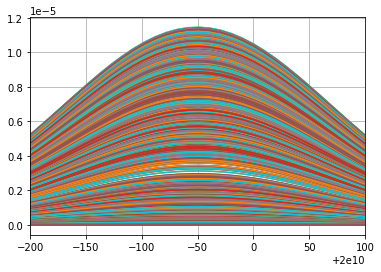

In [23]:
# Check one spectrum
_prefix = '{:.0f}GHz/'.format(20)
for i, _xy in enumerate(xy_list):
#for i, _xy in enumerate(xy_list[:3]):
    _x = _xy[0]
    _y = _xy[1]
    # Get the max power in frequency spectrum
    path = data_path + "{}{}_{}_{}_ON1.dat".format(_prefix, i, _x, _y)
    freq, ON1, tmperr = func.dat_to_array(path)
    path = data_path + "{}{}_{}_{}_ON2.dat".format(_prefix, i, _x, _y)
    freq, ON2, tmperr = func.dat_to_array(path)
    path = data_path + "{}{}_{}_{}_OFF1.dat".format(_prefix, i, _x, _y)
    freq, OFF1, tmperr = func.dat_to_array(path)
    path = data_path + "{}{}_{}_{}_OFF2.dat".format(_prefix, i, _x, _y)
    freq, OFF2, tmperr = func.dat_to_array(path)
    
    plt.plot(freq, ON1, label='ON1')
    plt.plot(freq, ON2, label='ON2')
    plt.plot(freq, OFF1, label='OFF1')
    plt.plot(freq, OFF2, label='OFF2')
    plt.grid(True)
    #plt.yscale('log')
    plt.xlim(20e+9-200,20e+9+100)
    #plt.ylim(0.,1.65e-8)
    pass

## 2D-Fit Function

#### def fit_func(): 2D Gaussian function

$$
f(x) = \mathrm{height} \times \exp{-\frac{(x-\bar{x})^2}{2\sigma^2}} \exp{-\frac{(y-\bar{y})^2}{2\sigma^2}}
$$

$\bar{x}$, $\bar{y}$ は x, y 方向のピーク位置、$\sigma$ は x 方向と y 方向で同じと仮定

In [10]:
def fit_func(x, y, height, mean_x, mean_y, sigma):
    return height * np.exp( - np.power((x-mean_x)/sigma, 2.) /2.) * np.exp( - np.power((y-mean_y)/sigma, 2.) /2.)

In [13]:
# Return a list of (Fit_func - data)/z_error
def residual(params, x, y, z, ze):
    height = params['height']
    mean_x = params['mean_x']
    mean_y = params['mean_y']
    sigma = params['sigma']

    y_model = fit_func(x, y, height, mean_x, mean_y, sigma)

    chi = (z - y_model)/ze
    o = np.isfinite(chi)
    return chi[o]

def predictParams(x, y, z):
    # Predict parameters
    height0 = max(z)
    index_peak0 = np.where(z==max(z))[0][0] # Get index of z-peak
    mean_x0 = x[index_peak0]
    mean_y0 = y[index_peak0]
    sigma0 = 100.
    return height0, mean_x0, mean_y0, sigma0

# Fit with a 2D gaussian
def fit_3D(x, y, z, ze, verbose=False, 
           height0=None, mean_x0=None, mean_y0=None, sigma0=None,
           fix=[False, False, False, False]):
    params = lmfit.Parameters()

    '''
    params.add('height', value=1.5e-5)
    params.add('mean_x', value=400.)
    params.add('mean_y', value=400.)
    params.add('sigma', value=100.)
    '''
    # Predict parameters
    _height0, mean_x0, _mean_y0, _sigma0 = predictParams(x, y, z)
    if height0 is None: height0 = _height0
    if mean_x0 is None: mean_x0 = _mean_x0
    if mean_y0 is None: mean_y0 = _mean_y0
    if sigma0 is None: sigma0 = _sigma0
    params.add('height', value=height0, vary=not fix[0])
    params.add('mean_x', value=mean_x0, vary=not fix[1])
    params.add('mean_y', value=mean_y0, vary=not fix[2])
    params.add('sigma', value=sigma0, vary=not fix[3])
    if verbose:
        print(f"    init height  : {height0}")
        print(f"    init mean  x : {mean_x0}")
        print(f"    init mean  y : {mean_y0}")
        print(f"    init sigma   : {sigma0}")
        pass
    
    result = lmfit.minimize(residual, params, args=(x, y, z, ze))

    h = result.params["height"].value
    he = result.params["height"].stderr
    mx = result.params["mean_x"].value
    my = result.params["mean_y"].value
    mxe = result.params["mean_x"].stderr
    mye = result.params["mean_y"].stderr
    s = np.abs(result.params["sigma"].value)
    se = result.params["sigma"].stderr
    FWHM = sigma_to_FWHM(mm_to_deg(s))
    chisqr = result.chisqr
    
    if verbose:
        print(f"height     : {h}")
        print(f"height_err : {he}")
        print(f"mean  x    : {mx}")
        print(f"sigma x    : {mxe}")
        print(f"mean  y    : {my}")
        print(f"sigma y    : {mye}")
        print(f"sigma      : {s}")
        print(f"sigma_err  : {se}")
        print(f"chisqr     : {chisqr:.3e}")
        print(f"FWHM : {FWHM}")
        print(f"FWHM*sqrt(2) considering two antennas: {np.sqrt(2.)*FWHM}")
        pass
    
    #z = fit_func(x, y, h, mx, my, s)
    #ax.errorbar(x, y, z, zerr = 0, fmt="x", markersize=5, color="r", label="fit result")
    
    return h, mx, my, mxe, mye, s, se, chisqr
           
def scan_initvalue_fit_3D(x, y, z, ze, verbose=False, scan_SFs=[0.5, 1.0, 1.5]):
    _height0, _mean_x0, _mean_y0, _sigma0 = predictParams(x, y, z)
    # fix height, mean_x/y
    _height0, _mean_x0, _mean_y0, _mxe, _mye, _sigma0, _se, _chisqr = fit_3D(
        x, y, z, ze, verbose=False,
        height0=_height0, mean_x0=_mean_x0, mean_y0=_mean_y0, sigma0=_sigma0,
        fix=[True,True,True,False])
    print(f'chisqr at the 1st fit = {_chisqr:.3e}')
    # fix height, sigma
    _height0, _mean_x0, _mean_y0, _mxe, _mye, _sigma0, _se, _chisqr = fit_3D(
        x, y, z, ze, verbose=False,
        height0=_height0, mean_x0=_mean_x0, mean_y0=_mean_y0, sigma0=_sigma0,
        fix=[True,False,False,True])
    print(f'chisqr at the 2nd fit = {_chisqr:.3e}')
    # fix height, sigma
    _height0, _mean_x0, _mean_y0, _mxe, _mye, _sigma0, _se, _chisqr = fit_3D(
        x, y, z, ze, verbose=False,
        height0=_height0, mean_x0=_mean_x0, mean_y0=_mean_y0, sigma0=_sigma0,
        fix=[True,False,False,True])
    print(f'chisqr at the 3rd fit = {_chisqr:.3e}')
    # No fix
    _height0, _mean_x0, _mean_y0, _mxe, _mye, _sigma0, _se, _chisqr = fit_3D(
        x, y, z, ze, verbose=False,
        height0=_height0, mean_x0=_mean_x0, mean_y0=_mean_y0, sigma0=_sigma0,
        fix=[False,False,False,False])
    print(f'chisqr at the 4th fit = {_chisqr:.3e}')
    
    scan_SFs = np.array(scan_SFs)
    height_scan = np.array(_height0*scan_SFs)
    mean_x_scan = np.array(_mean_x0*scan_SFs)
    mean_y_scan = np.array(_mean_y0*scan_SFs)
    sigma_scan = np.array(_sigma0*scan_SFs)
    
    height_grid, mean_x_grid, mean_y_grid, sigma_grid = np.meshgrid(height_scan, mean_x_scan, mean_y_scan, sigma_scan) # 2D grid in x-axis / y-axis                                                       
    height_scan = height_grid.reshape(-1) # flatten to 1D array                                                                         
    mean_x_scan = mean_x_grid.reshape(-1) # flatten to 1D array                                                                         
    mean_y_scan = mean_y_grid.reshape(-1) # flatten to 1D array                                                                         
    sigma_scan = sigma_grid.reshape(-1) # flatten to 1D array                                                                         
    # create list of (height, mean_x, mean_y, sigma) 
    par_list = np.stack((height_scan, mean_x_scan, mean_y_scan, sigma_scan), axis=1) 
    
    chisqr_list = []
    for i, (height0, mean_x0, mean_y0, sigma0) in enumerate(par_list):
        h, mx, my, mxe, mye, s, se, chisqr = fit_3D(
            x, y, z, ze, verbose=False,
            height0=height0, mean_x0=mean_x0, mean_y0=mean_y0, sigma0=sigma0)
        chisqr_list.append(chisqr)
        pass
    min_chisqr = min(chisqr_list)
    index_min = chisqr_list.index(min_chisqr)
    par_min = par_list[index_min]
    height0 = par_min[0]
    mean_x0 = par_min[1]
    mean_y0 = par_min[2]
    sigma0 = par_min[3]
    print(f'Minimum chisqr = {min_chisqr:.3e} (i={index_min})')
   
    # Fit again with minimum parameter set
    h, mx, my, mxe, mye, s, se, chisqr = fit_3D(
        x, y, z, ze, verbose=verbose,
        height0=height0, mean_x0=mean_x0, mean_y0=mean_y0, sigma0=sigma0)
        
    return h, mx, my, mxe, mye, s, se, chisqr



## Fit x-y map with a 2D gaussian for all frequencies

In [14]:
# Plot x-y map for a specific frequency
def plotXYmap(freq=19., data_path=data_path, 
              xy_list=xy_list, outdir=outdir, suffix=''):
    x, y, z, ze = get_power(freq, data_path, xy_list)
    cm = plt.cm.get_cmap('RdYlBu')
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)

    mappable = ax.scatter(x, y, c=z, vmin=0, vmax=3e-5, s=30, cmap=cm)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title("{:.1f} GHz".format(freq))
 
    fig.colorbar(mappable, ax=ax)

    plt.savefig('{}/colormap_{}GHz{}.pdf'.format(outdir, freq, suffix))
    return

In [15]:
for _freq_str in freqs_str:
    _freq = (float(_freq_str))
    print(f'### Fit at {_freq} GHz... ###')
    ## Get x-y data
    x, y, z, ze = get_power(freq=_freq, data_path=data_path, xy_list=xy_list)
    fit_result[_freq_str]["x"] = x
    fit_result[_freq_str]["y"] = y
    fit_result[_freq_str]["z"] = z
    fit_result[_freq_str]["ze"] = ze
    
    ## Fit with 2D-Gauusian
    #h, mx, my, mxe, mye, s, se = fit_3D(x, y, z, ze, verbose=True if _freq==19. else False)
    #h, mx, my, mxe, mye, s, se, chisqr = scan_initvalue_fit_3D(x, y, z, ze, verbose=True, scan_SFs=[0.5, 1.0, 1.5])
    h, mx, my, mxe, mye, s, se, chisqr = scan_initvalue_fit_3D(x, y, z, ze, verbose=True, scan_SFs=[1.0])
    fit_result[_freq_str]["h"] = h
    fit_result[_freq_str]["mx"] = mx
    fit_result[_freq_str]["my"] = my
    fit_result[_freq_str]["mxe"] = mxe
    fit_result[_freq_str]["mye"] = mye
    fit_result[_freq_str]["s"] = s
    fit_result[_freq_str]["se"] = se
    fit_result[_freq_str]["chisqr"] = chisqr
    pass

### Fit at 18.0 GHz... ###
chisqr at the 1st fit = 3.091e+12
chisqr at the 2nd fit = 2.574e+12
chisqr at the 3rd fit = 2.574e+12
chisqr at the 4th fit = 9.656e+11
Minimum chisqr = 9.656e+11 (i=0)
    init height  : 1.5799456067487028e-05
    init mean  x : 422.0
    init mean  y : 427.2299911842457
    init sigma   : 121.00257819674725
height     : 1.579946803826957e-05
height_err : 2.96238874570395e-07
mean  x    : 413.1958533846428
sigma x    : 1.4708968628832413
mean  y    : 427.22975988915016
sigma y    : 1.8427893892611131
sigma      : 121.00249112545454
sigma_err  : 0.7408221762428066
chisqr     : 9.656e+11
FWHM : 14.984907414703597
FWHM*sqrt(2) considering two antennas: 21.191859296778983
### Fit at 19.0 GHz... ###
chisqr at the 1st fit = 4.743e+13
chisqr at the 2nd fit = 1.522e+13
chisqr at the 3rd fit = 1.522e+13
chisqr at the 4th fit = 4.076e+11
Minimum chisqr = 4.067e+11 (i=0)
    init height  : 2.069109480246676e-05
    init mean  x : 412.0
    init mean  y : 423.7209695981

## Plot x-y map

In [8]:
# Plot x-y map for a specific frequency
def plotXYmap(freq=19., data_path=data_path, 
              xy_list=xy_list, outdir=outdir, suffix=''):
    x, y, z, ze = get_power(freq, data_path, xy_list)
    cm = plt.cm.get_cmap('RdYlBu')
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)

    mappable = ax.scatter(x, y, c=z, vmin=0, vmax=3e-5, s=30, cmap=cm)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title("{:.1f} GHz".format(freq))
 
    fig.colorbar(mappable, ax=ax)

    plt.savefig('{}/colormap_{}GHz{}.pdf'.format(outdir, freq, suffix))
    return

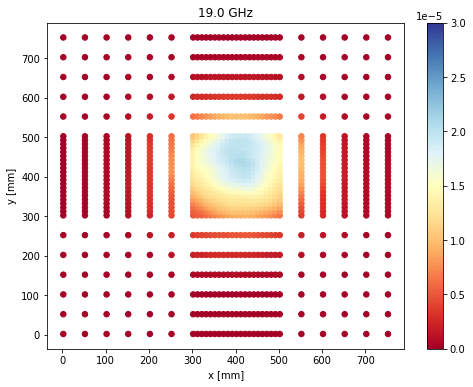

In [9]:
# Plot 19 GHz
plotXYmap(freq=19., data_path=data_path, xy_list=xy_list, outdir=outdir, suffix='')

## Retrieve x-slice & y-slice at the center at a specific frequency (`_freq_str`)

In [16]:
def get_xyslice(freq_str, fit_result=fit_result):
    x = fit_result[_freq_str]['x']
    y = fit_result[_freq_str]['y']
    z = fit_result[_freq_str]['z']
    ze = fit_result[_freq_str]['ze']

    xy = [] # points of x where y is center
    zy = []
    zye = []
    yx = [] # points of y where x is center
    zx = []
    zxe = []

    for _x, _y, _z, _ze, in zip(x, y, z, ze):
        # Get y-slice at maximum
        # x is center
        if _x == 402:
            yx.append(_y)
            zx.append(_z)
            zxe.append(_ze)
            pass
        # Get x-slice at maximum
        # y is center
        if _y == 422:
            xy.append(_x)
            zy.append(_z)
            zye.append(_ze)
            pass
        pass
 
    return xy, zy, zye, yx, zx, zxe

def plot_xyslice(freq_str, outdir=outdir, fit_result=fit_result, show=True):
    xy = fit_result[_freq_str]['xy']
    zy = fit_result[_freq_str]['zy']
    zye = fit_result[_freq_str]['zye']
    yx = fit_result[_freq_str]['yx']
    zx = fit_result[_freq_str]['zx']
    zxe = fit_result[_freq_str]['zxe']
    
    # Get FHWM
    zx_max = max(zx)
    zy_max = max(zy)
    half_zx_max = zx_max/2.
    half_zy_max = zy_max/2.
    # Spline interpolation to z - half max
    yx_spline = np.linspace(yx[0], yx[-1], 1000)
    xy_spline = np.linspace(xy[0], xy[-1], 1000)
    spline_zx = interpolate.interp1d(yx, zx, kind='cubic')
    spline_zy = interpolate.interp1d(xy, zy, kind='cubic')
    zx_spline = spline_zx(yx_spline)
    zy_spline = spline_zy(xy_spline)
    # Get roots at z=0
    yx_half_max = getX(yx_spline, zx_spline, half_zx_max)
    xy_half_max = getX(xy_spline, zy_spline, half_zy_max)
    if len(yx_half_max)!=2:
        print('Error! Failed to y values (y-slice) with z=max/2. ')
        print(f'Number of y values should be 2 but it was {len(yx_half_max)}')
        return -1
    if len(xy_half_max)!=2:
        print('Error! Failed to x values (x-slice) with z=max/2. ')
        print(f'Number of x values should be 2 but it was {len(yx_half_max)}')
        return -1
    # Calculate FHWM
    FWHMmm_zx = yx_half_max[1] - yx_half_max[0]
    FWHMmm_zy = xy_half_max[1] - xy_half_max[0]
    FWHMmm_zx_err = np.sqrt( get_interval(yx, yx_half_max[0])**2. + get_interval(yx, yx_half_max[1])**2. ) # come from interval of scan in y
    FWHMmm_zy_err = np.sqrt( get_interval(xy, xy_half_max[0])**2. + get_interval(xy, xy_half_max[1])**2. ) # come from interval of scan in y
    print(f'    FWHMmm_zx_err = {FWHMmm_zx_err:.1f} mm')
    print(f'    FWHMmm_zy_err = {FWHMmm_zy_err:.1f} mm')
    FWHM_zx = mm_to_deg(FWHMmm_zx)
    FWHM_zy = mm_to_deg(FWHMmm_zy)
    # error is calculated from the (up - down)/2
    FWHM_zx_err = ( mm_to_deg(FWHMmm_zx+FWHMmm_zx_err)-mm_to_deg(FWHMmm_zx-FWHMmm_zx_err) )/2.
    FWHM_zy_err = ( mm_to_deg(FWHMmm_zy+FWHMmm_zy_err)-mm_to_deg(FWHMmm_zy-FWHMmm_zy_err) )/2.
    print(f'    FWHM_zx_err = {FWHM_zx_err:.1f} deg')
    print(f'    FWHM_zy_err = {FWHM_zy_err:.1f} deg')
    fit_result[_freq_str]['FWHMmm_zy'] = FWHMmm_zy
    fit_result[_freq_str]['FWHMmm_zx_err'] = FWHMmm_zx_err
    fit_result[_freq_str]['FWHMmm_zy_err'] = FWHMmm_zy_err
    fit_result[_freq_str]['FWHM_zx'] = FWHM_zx
    fit_result[_freq_str]['FWHM_zy'] = FWHM_zy
    fit_result[_freq_str]['FWHM_zx_err'] = FWHM_zx_err
    fit_result[_freq_str]['FWHM_zy_err'] = FWHM_zy_err
   
    # Plot y-slice / x-slice
    plt.rcParams["font.size"] = 18
    fig, axes = plt.subplots(1,2,figsize=(15,6), squeeze=False)
    fig.suptitle("{} GHz".format(_freq_str))

    # x is center (y-slice)
    ax = axes[0][0]
    ax.errorbar(yx, zx, yerr = zxe, capsize=0, fmt='x', markersize=10, 
                ecolor='blue', markeredgecolor = "blue", color='blue', label="data")
    ax.plot(yx, gauss_1d(yx, fit_result[freq_str]["h"], fit_result[freq_str]["my"], fit_result[freq_str]["s"]), 
            color="red", label="fit result")
    ax.plot(yx_spline, [half_zx_max]*len(yx_spline), color='blue', markersize=0, linestyle='--', label='Half maximum')
    ax.plot(yx_spline, spline_zx(yx_spline), color='blue', markersize=0, linestyle='-', label='Spline fit')
    ax.fill_between(yx_half_max, [0., 0.], [half_zx_max*2.]*2, color='blue', linestyle='-', alpha=0.2)
    ax.set_xlabel("y [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("x is center")
    ax.grid()
    ax.legend(fontsize=12)

    # y is center (x-slice)
    ax = axes[0][1]
    ax.errorbar(xy, zy, yerr = zye, capsize=0, fmt='x', markersize=10, 
                ecolor='blue', markeredgecolor = "blue", color='blue', label="data")
    ax.plot(xy, gauss_1d(xy, fit_result[freq_str]["h"], fit_result[freq_str]["mx"], fit_result[freq_str]["s"]), 
            color="red", label="fit result")
    ax.plot(xy_spline, [half_zy_max]*len(xy_spline), color='blue', markersize=0, linestyle='--', label='Half maximum')
    ax.plot(xy_spline, spline_zy(xy_spline), color='blue', markersize=0, linestyle='-', label='Spline fit')
    ax.fill_between(xy_half_max, [0., 0.], [half_zy_max*2.]*2, color='blue', linestyle='-', alpha=0.2)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("y is center")
    ax.grid()
    ax.legend(fontsize=12)
    
    plt.savefig("{}/center_{}GHz.pdf".format(outdir, _freq_str))
    if not show: plt.close()
    return

### Get xy slice for all frequencies

    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 70.7 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 3.5 deg
    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 70.7 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 3.5 deg
    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 70.7 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 3.5 deg
    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 51.0 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 2.6 deg
    FWHMmm_zx_err = 22.6 mm
    FWHMmm_zy_err = 51.0 mm
    FWHM_zx_err = 1.2 deg
    FWHM_zy_err = 2.6 deg
    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 68.5 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 3.4 deg
    FWHMmm_zx_err = 51.0 mm
    FWHMmm_zy_err = 51.0 mm
    FWHM_zx_err = 2.6 deg
    FWHM_zy_err = 2.6 deg
    FWHMmm_zx_err = 46.5 mm
    FWHMmm_zy_err = 51.0 mm
    FWHM_zx_err = 2.4 deg
    FWHM_zy_err = 2.6 deg
    FWHMmm_zx_err = 23.9 mm
    FWHMmm_zy_err = 51.0 mm
    FWHM_zx_err = 1.2 deg
    FWHM_zy_err = 2.6 deg


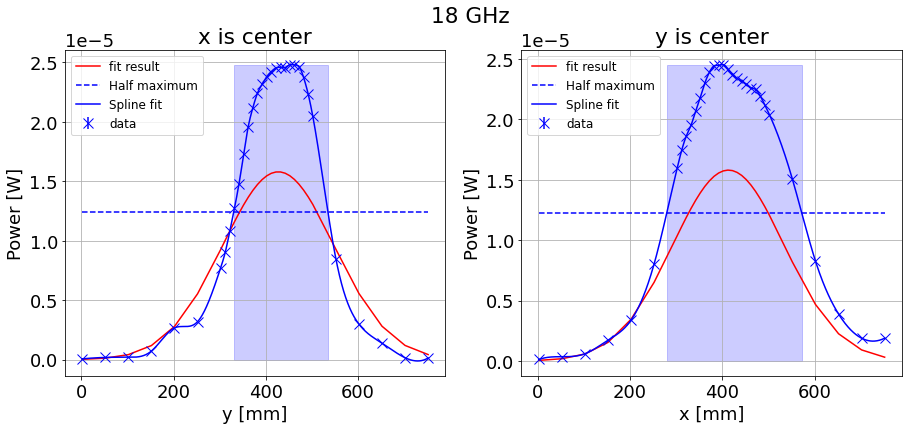

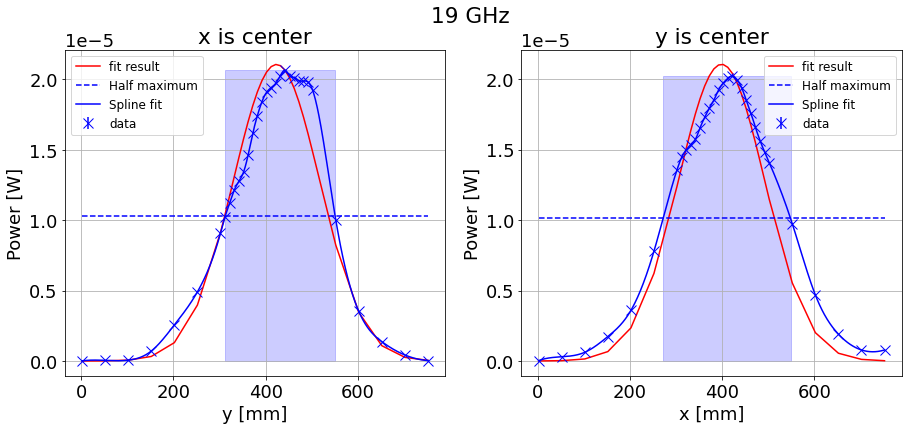

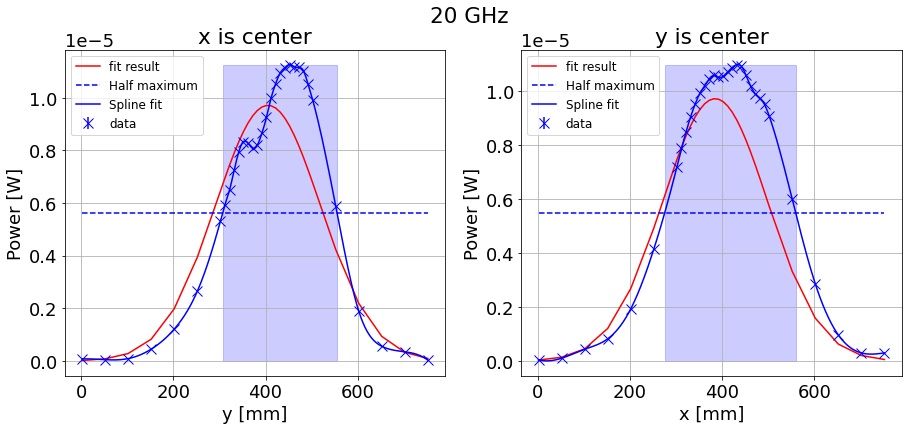

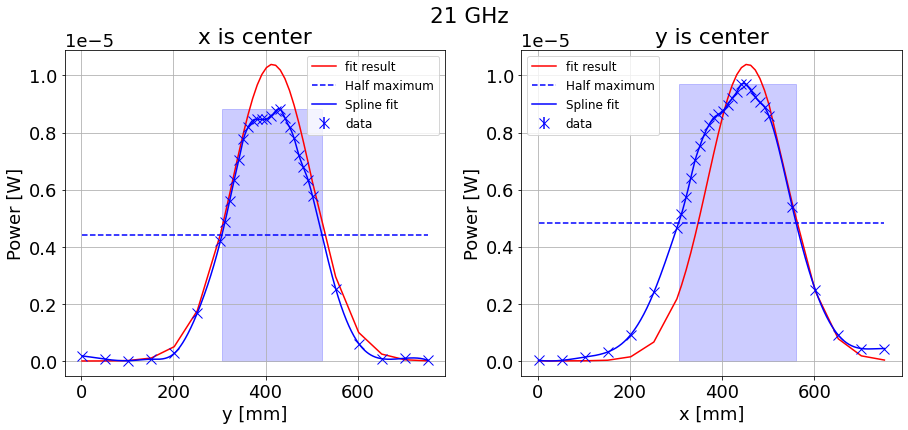

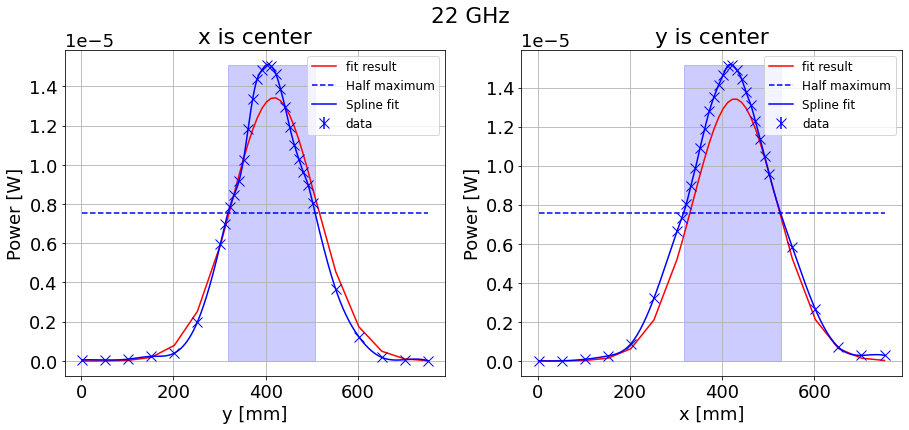

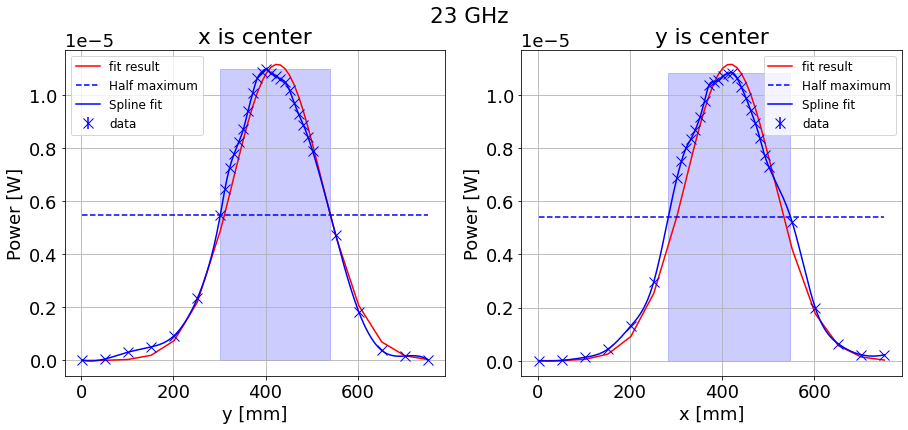

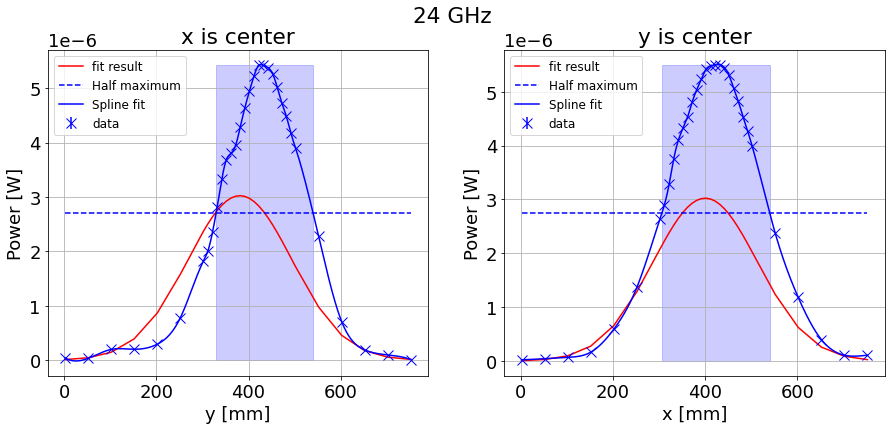

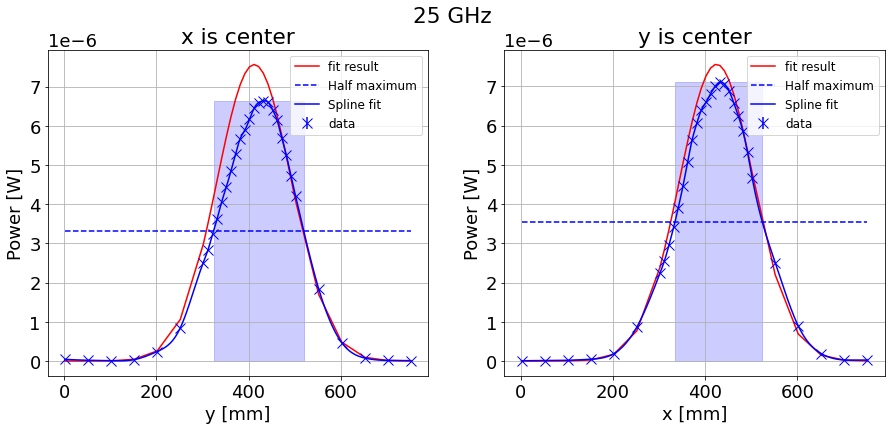

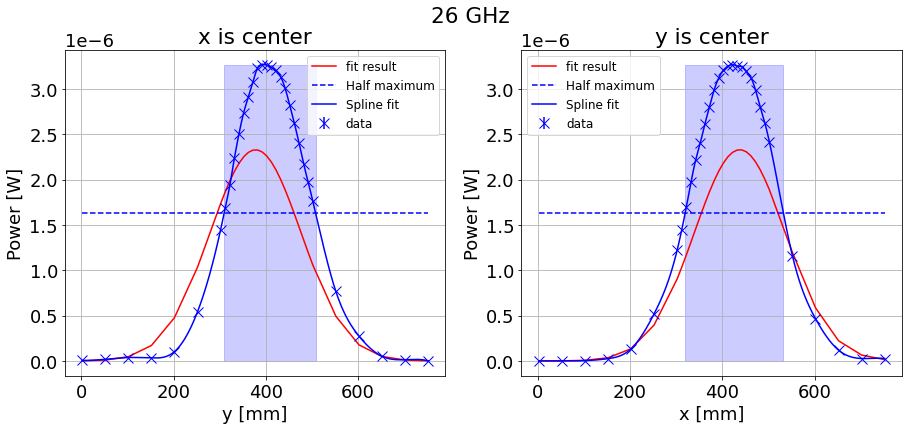

In [17]:
for _freq_str in freqs_str:
    xy, zy, zye, yx, zx, zxe = get_xyslice(_freq_str, fit_result=fit_result)
    fit_result[_freq_str]['xy'] = xy
    fit_result[_freq_str]['zy'] = zy
    fit_result[_freq_str]['zye'] = zye
    fit_result[_freq_str]['yx'] = yx
    fit_result[_freq_str]['zx'] = zx
    fit_result[_freq_str]['zxe'] = zxe
    # Plot & Calculate FWHM
    plot_xyslice(_freq_str, outdir=outdir, fit_result=fit_result, show=True)
    pass

## Plot FWHM

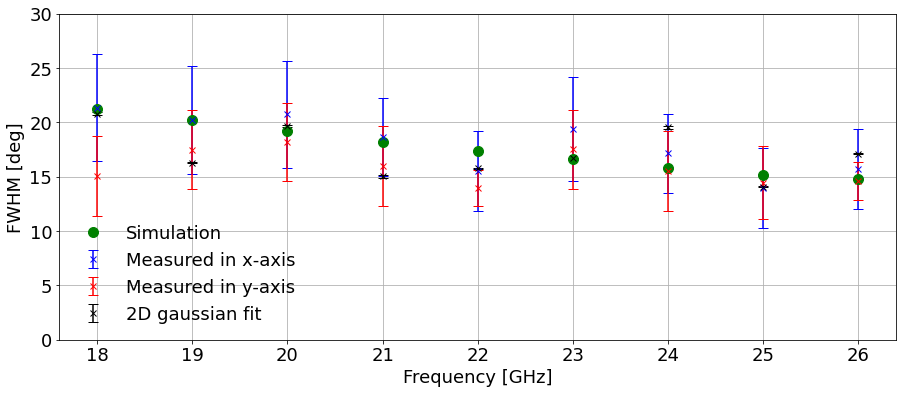

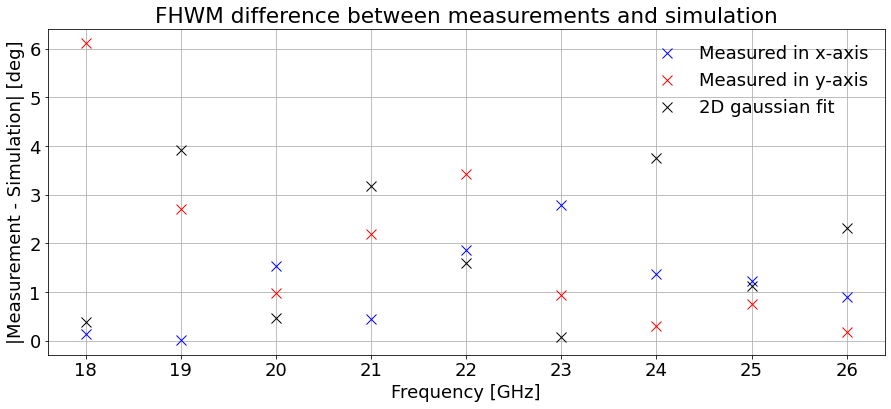

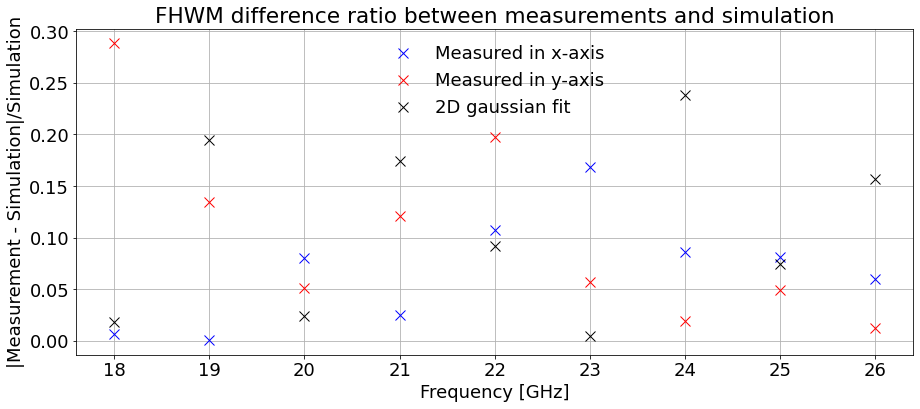

In [18]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

FWHM_zx_list = []
FWHM_zx_err_list = []
FWHM_zy_list = []
FWHM_zy_err_list = []
FWHM_fit_list = []
FWHM_fit_err_list = []
for _freq_str in freqs_str:
    _result = fit_result[_freq_str]
    FWHM_zx_list.append(_result['FWHM_zx']*np.sqrt(2.))
    FWHM_zx_err_list.append(_result['FWHM_zx_err']*np.sqrt(2.))
    FWHM_zy_list.append(_result['FWHM_zy']*np.sqrt(2.))
    FWHM_zy_err_list.append(_result['FWHM_zy_err']*np.sqrt(2.))
    FWHM_fit_list.append( mm_to_deg(sigma_to_FWHM(_result['s'])) *np.sqrt(2.) )
    FWHM_fit_err_list.append( mm_to_deg(sigma_to_FWHM(_result['se'])) *np.sqrt(2.) )
    pass

# FWHM plot
plt.errorbar(freqs, FWHM_simulation, marker='o', markersize=10, color="green", label="Simulation", linestyle='')
plt.errorbar(freqs, FWHM_zy_list, yerr=FWHM_zy_err_list, capsize=5, marker="x", color="blue", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, FWHM_zx_list, yerr=FWHM_zx_err_list, capsize=5, marker="x", color="red", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, FWHM_fit_list, yerr=FWHM_fit_err_list, capsize=5, marker="x", color="k", label="2D gaussian fit", linestyle='')

plt.ylim([0, 30])
plt.grid()
plt.legend(frameon=False)
#plt.title("FWHM")
plt.ylabel("FWHM [deg]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/fwhm.pdf")

# Diff. plot
plt.figure(figsize=(15,6))
plt.errorbar(freqs, abs(FWHM_zy_list-FWHM_simulation), capsize=0, marker="x", markersize=10, color="blue", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, abs(FWHM_zx_list-FWHM_simulation), capsize=0, marker="x", markersize=10, color="red", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, abs(FWHM_fit_list-FWHM_simulation), capsize=0, marker="x", markersize=10, color="k", label="2D gaussian fit", linestyle='')
plt.grid()
plt.legend(frameon=False)
plt.title("FHWM difference between measurements and simulation")
plt.ylabel("|Measurement - Simulation| [deg]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/fwhm_diff.pdf")

# Diff. ratio plot
plt.figure(figsize=(15,6))
plt.errorbar(freqs, abs(FWHM_zy_list-FWHM_simulation)/FWHM_simulation, capsize=0, marker="x", markersize=10, color="blue", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, abs(FWHM_zx_list-FWHM_simulation)/FWHM_simulation, capsize=0, marker="x", markersize=10, color="red", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, abs(FWHM_fit_list-FWHM_simulation)/FWHM_simulation, capsize=0, marker="x", markersize=10, color="k", label="2D gaussian fit", linestyle='')
plt.grid()
plt.legend(frameon=False)
plt.title("FHWM difference ratio between measurements and simulation")
plt.ylabel("|Measurement - Simulation|/Simulation")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/fwhm_diffratio.pdf")


## Plot center position  `(x_mean, y_mean)` at each frequency

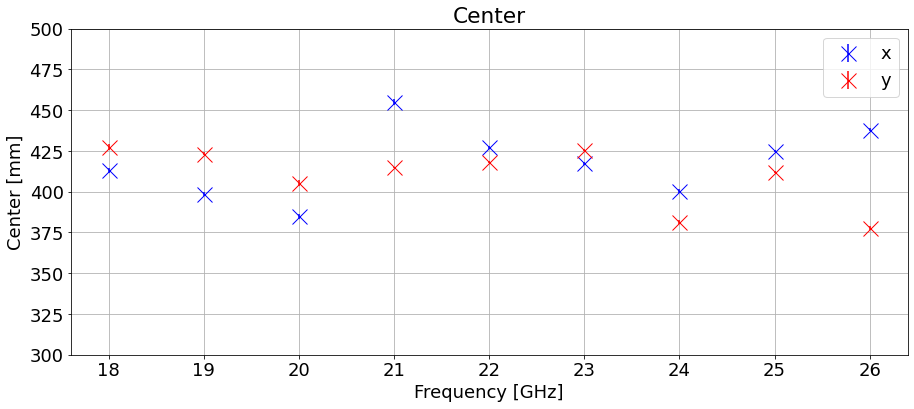

In [19]:
# Plot 
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

for _freq_str in freqs_str:
    plt.errorbar((float)(_freq_str), fit_result[_freq_str]["mx"], yerr=fit_result[_freq_str]["mxe"], markersize=15, fmt="x", capsize=0, color="blue")
    plt.errorbar((float)(_freq_str), fit_result[_freq_str]["my"], yerr=fit_result[_freq_str]["mye"], markersize=15, fmt="x", capsize=0, color="red")
    pass

plt.errorbar(20, 0, yerr=0, markersize=15, fmt="x", capsize=0, color="blue", label="x")
plt.errorbar(20, 0, yerr=0, markersize=15, fmt="x", capsize=0, color="red", label="y")
plt.ylim([300, 500])
plt.grid()
plt.legend()
plt.title("Center")
plt.ylabel("Center [mm]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/center.pdf")

## Plot sigma at each frequency

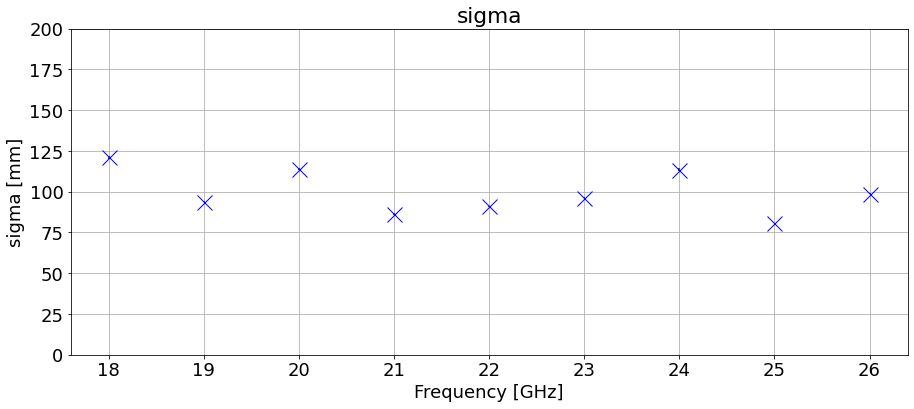

In [20]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

for _freq_str in freqs_str:
    plt.errorbar(_freq_str, fit_result[_freq_str]["s"], yerr=fit_result[_freq_str]["se"], markersize=15, fmt="x", capsize=0, color="blue")
    pass

plt.ylim([0, 200])
plt.grid()
plt.title("sigma")
plt.ylabel("sigma [mm]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/sigma.pdf")

# X/Y-slice  Measurement

## Input Data Information

In [21]:
data_dir = '2022-03-08_cycle'
data_path = f'/data/xy_scan/{data_dir}/'
n_meas = 3

y_ycen = np.array([412])
x_ycen = np.arange(5, 765, 10)
xy_label_ycen ='Y'
_x_grid, _y_grid = np.meshgrid(x_ycen, y_ycen) # 2D grid in x-axis / y-axis                                                       
_xx = _x_grid.reshape(-1) # flatten to 1D array                                                                         
_yy = _y_grid.reshape(-1) # flatten to 1D array                                                                         
xy_list_ycen = np.stack((_xx, _yy), axis=1) # create list of (x,y) 

x_xcen = np.array([412])
y_xcen = np.arange(5, 765, 10)
xy_label_xcen ='X'
_x_grid, _y_grid = np.meshgrid(x_xcen, x_ycen) # 2D grid in x-axis / y-axis                                                       
_xx = _x_grid.reshape(-1) # flatten to 1D array                                                                         
_yy = _y_grid.reshape(-1) # flatten to 1D array                                                                         
xy_list_xcen = np.stack((_xx, _yy), axis=1) # create list of (x,y) 

In [22]:
outdir = './plot/result_figure/xy_scan/'
outdir_ycen = '{}/2022-03-08_{}slice_{}measure'.format(outdir, xy_label_ycen, n_meas)
if not os.path.isdir(outdir_ycen):
    os.makedirs(outdir_ycen)
    pass

outdir_xcen = '{}/2022-03-08_{}slice_{}measure'.format(outdir, xy_label_xcen, n_meas)
if not os.path.isdir(outdir_xcen):
    os.makedirs(outdir_xcen)
    pass

## Functions for X/Y-slice measurement

In [23]:
def gauss1d_residual(params, x, y, yerr):
    mean = params['mean']
    sigma = params['sigma']
    height = params['height']
    y_model = gauss_1d(x, height, mean, sigma)
    chi = (y - y_model)/yerr
    a = np.isfinite(chi)
    return chi[a]

def num(text):
    if text == 0: return "1st"
    if text == 1: return "2nd"
    if text == 2: return "3rd"
    if text == 3: return "4th"
    if text == 4: return "5th"

In [24]:
def plotSlice_power(ax, freq_str, data_path=data_path, xy='Y', n_meas=n_meas, xy_list=xy_list):
    z_list = []
    for i in range(n_meas):
        input_path = data_path + '{}GHz_{}_{}/'.format(freq_str, i, xy)
        x, y, z, ze = get_power(freq_str, input_path, xy_list=xy_list, prefix='')
        a = x if xy=='Y' else y # x-axis
        ax.plot(a, z, label=num(i))
        z_list.append(z)
        #ax.scatter(y, z, label=num(i), marker="x", s=200)
        pass

    ax.set_xlabel("Position [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("{} GHz".format(freq_str))
    ax.set_ylim([-0.2e-5, 2.7e-5])
    ax.grid()
    ax.legend(loc="upper left", fontsize=12)
    
    # Averaging
    z_ave = np.average( z_list, axis=0 )
    
    # Get FHWM
    z_max = max(z_ave)
    half_z_max = z_max/2.
    # Spline interpolation to z - half max
    a_spline = np.linspace(a[0], a[-1], 1000) # x-axis array for spline function
    spline_a = interpolate.interp1d(a, z_ave, kind='cubic')
    z_spline = spline_a(a_spline)
    # Get roots at z=0
    a_half_max = getX(a_spline, z_spline, half_z_max)
    if len(a_half_max)!=2:
        print('Error! Failed to a values with z=max/2. ')
        print(f'Number of a values should be 2 but it was {len(a_half_max)}')
        return -1
    # Calculate FHWM
    FWHMmm = a_half_max[1] - a_half_max[0]
    FWHMmm_err = np.sqrt( get_interval(a, a_half_max[0])**2. + get_interval(a, a_half_max[1])**2. ) # come from interval of scan in a
    print(f'    FWHMmm_err = {FWHMmm_err:.1f} mm')
    FWHM = mm_to_deg(FWHMmm)
    # error is calculated from the (up - down)/2
    FWHM_err = ( mm_to_deg(FWHMmm+FWHMmm_err)-mm_to_deg(FWHMmm-FWHMmm_err) )/2.
    print(f'    FWHM_err = {FWHM_err:.1f} deg')
    
    # Plot FWHM lines
    ax.plot([a[0], a[-1]], [half_z_max, half_z_max], linestyle='--', color='red')
    ax.fill_between([a_half_max[0], a_half_max[1]], [half_z_max, half_z_max], linestyle=':', color='red', alpha=0.3)
    
    return FWHM, FWHM_err
    
def plotSlice_fit(ax, freq_str, data_path=data_path, xy='Y', n_meas=n_meas, xy_list=xy_list):
    x = np.zeros(len(xy_list))
    y = np.zeros(len(xy_list))
    z = np.zeros(len(xy_list))
    ze = np.zeros(len(xy_list))
    for i in range(n_meas):
        input_path = f'{data_path}/{freq_str}GHz_{i}_{xy}/'
        xx, yy, zz, zze = get_power(freq_str, input_path, xy_list, prefix='')
        x += xx
        y += yy
        z += zz
        ze += zze
        pass
        
    x_ave = x/n_meas if xy=='Y' else y/n_meas
    z_ave = z/n_meas
    z_ave_err = ze/n_meas
        
    # data
    # ax.plot(hol, ver, color="blue")
    ax.errorbar(x_ave, z_ave, yerr=z_ave_err, label="mean of {}".format(n_meas), markersize=1, color="blue", marker='o')
    
    # fit
    params = lmfit.Parameters()
    params.add('height', value=1.e-5)
    params.add('mean', value=400.)
    params.add('sigma', value=100.)

    result = lmfit.minimize(gauss1d_residual, params, args=(x_ave, z_ave, z_ave_err))
    height = result.params["height"].value
    mean = result.params["mean"].value
    mean_err = result.params["mean"].stderr
    sigma = result.params["sigma"].value
    sigma_err = result.params["sigma"].stderr
    FWHMmm = sigma_to_FWHM(sigma)
    FWHMmm_err = sigma_to_FWHM(sigma_err)
    FWHM = mm_to_deg(FWHMmm)
    FWHM_err = mm_to_deg(FWHMmm_err)
    ax.plot(x_ave, gauss_1d(x_ave, height, mean, sigma), label="fit result", color="r", linestyle='-', linewidth=3)
    ax.text(0.62, 0.85, r"$\sigma$ = " + str(round(sigma,1)) + r"$\pm$" + str(round(sigma_err,1)), transform=ax.transAxes)
    print(f'sigma = {sigma:.2f} +- {sigma_err:.2f} mm')
    print(f'FWHMmm = {FWHMmm:.2f} +- {FWHMmm_err:.2f} mm')
    print(f'FWHM = {FWHM:.2f} +- {FWHM_err:.2f} deg.')
    print(f'FWHM for one antenna = {FWHM*np.sqrt(2.):.2f} +- {FWHM_err*np.sqrt(2.):.2f} deg.')

    # setting
    ax.set_xlabel("Position [mm]")
    ax.set_ylabel("Power [W]")
    ax.set_title("{} GHz".format(freq_str))
    ax.set_ylim([-0.2e-5, 2.7e-5])
    ax.grid()
    ax.legend(loc="upper left")
    return sigma, sigma_err, FWHM, FWHM_err

## Plot Power at Y-center

axis index = (0, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (0, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (0, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg


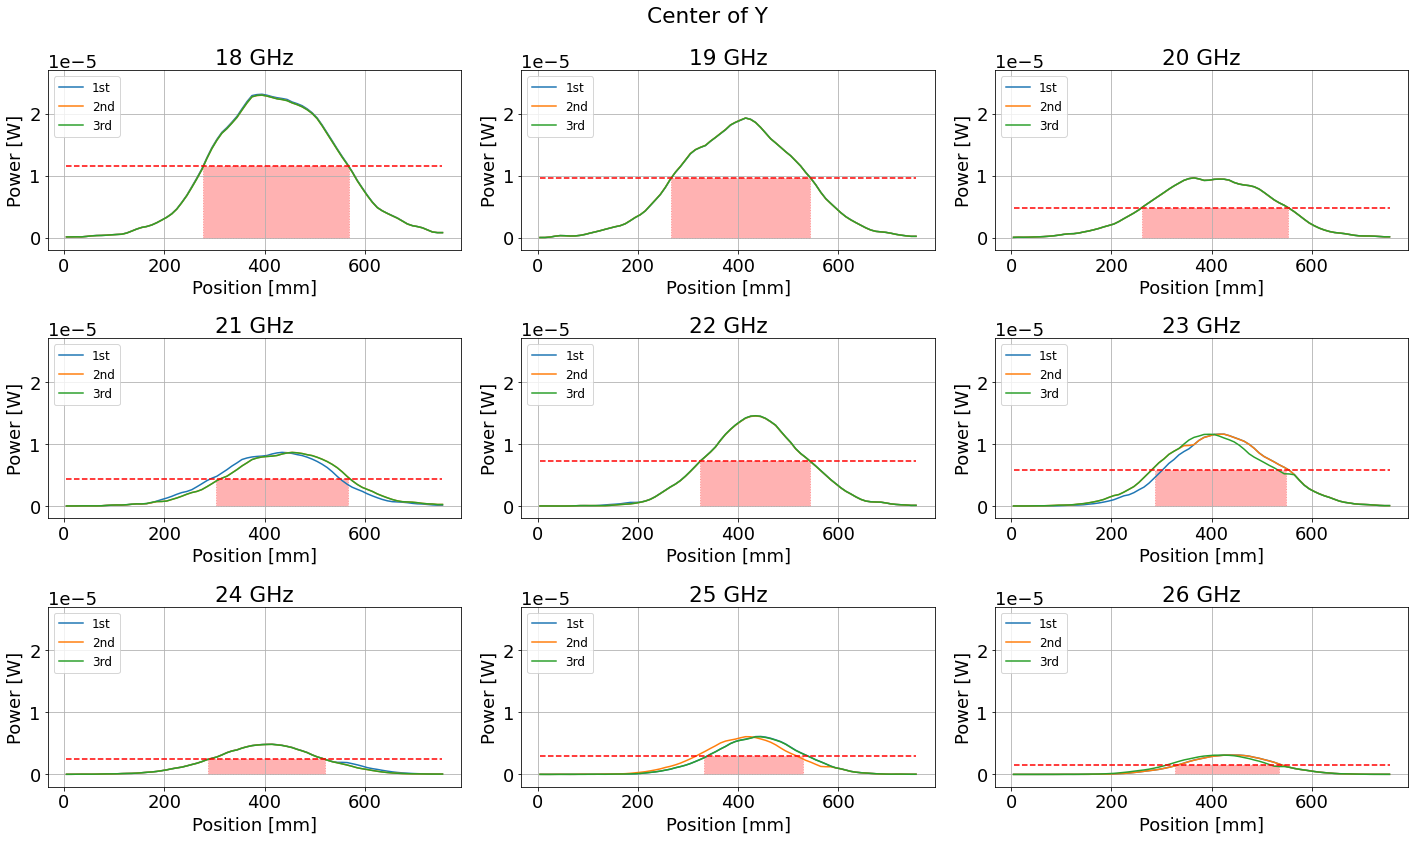

In [25]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle(f"Center of {xy_label_ycen}")
FWHM_ycen = []
FWHM_err_ycen = []
for i, _freq_str in enumerate(freqs_str):
    i_ax = (int)(i/3.)
    j_ax = i%3
    print(f'axis index = ({i_ax}, {j_ax})')
    _FWHM, _FWHM_err = plotSlice_power(axes[i_ax][j_ax], _freq_str, xy=xy_label_ycen, xy_list=xy_list_ycen, data_path=data_path)
    FWHM_ycen.append(_FWHM)
    FWHM_err_ycen.append(_FWHM_err)
    pass
fig.tight_layout()
plt.savefig(f"{outdir_ycen}/power.pdf")

## Plot Power at X-center

axis index = (0, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (0, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (0, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (1, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 0)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 1)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg
axis index = (2, 2)
    FWHMmm_err = 14.1 mm
    FWHM_err = 0.7 deg


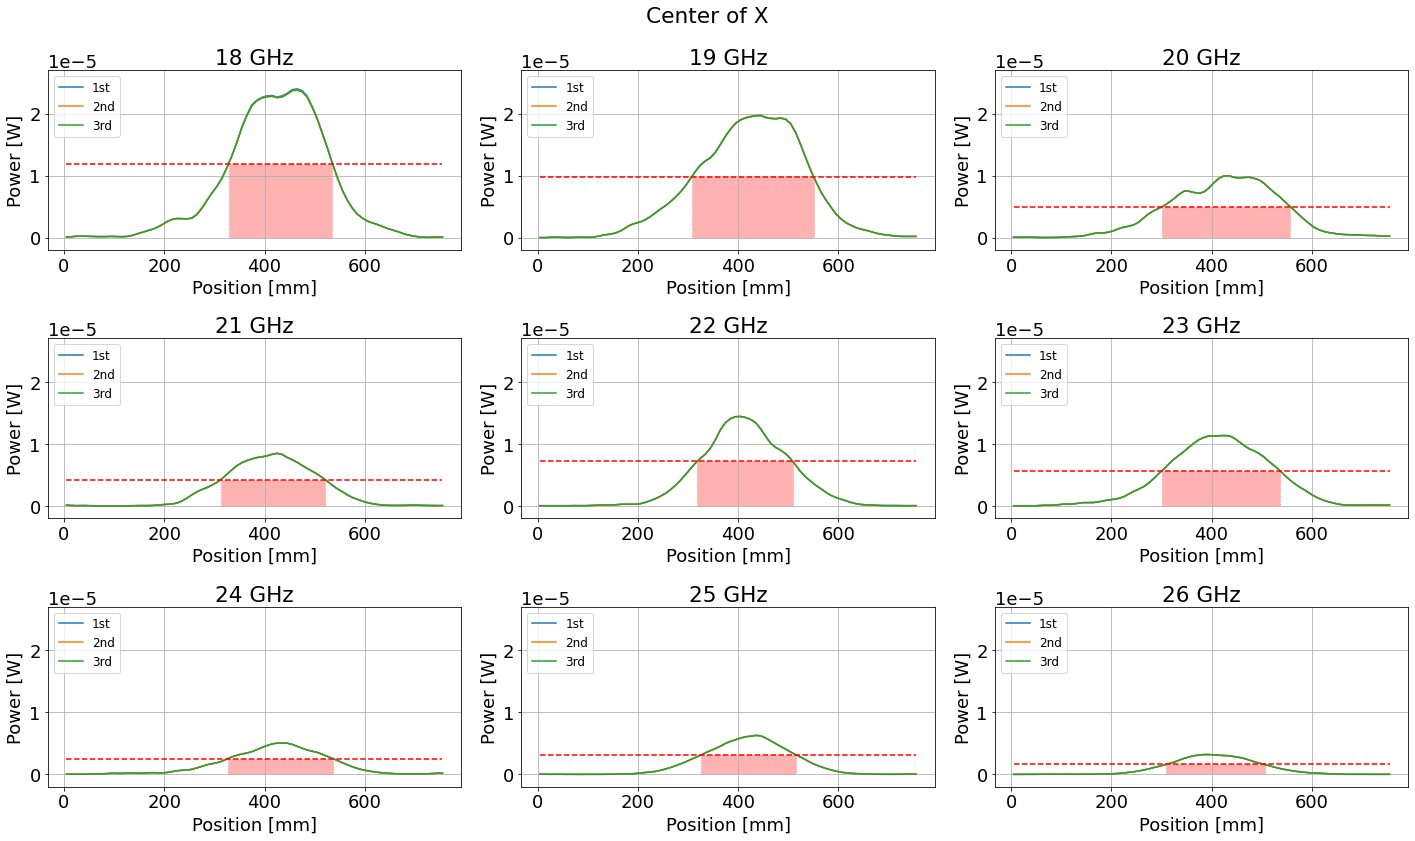

In [26]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle(f"Center of {xy_label_xcen}")
FWHM_xcen = []
FWHM_err_xcen = []
for i, _freq_str in enumerate(freqs_str):
    i_ax = (int)(i/3.)
    j_ax = i%3
    print(f'axis index = ({i_ax}, {j_ax})')
    _FWHM, _FWHM_err = plotSlice_power(axes[i_ax][j_ax], _freq_str, xy=xy_label_xcen, xy_list=xy_list_xcen, data_path=data_path)
    FWHM_xcen.append(_FWHM)
    FWHM_err_xcen.append(_FWHM_err)
    pass
fig.tight_layout()
plt.savefig(f"{outdir_xcen}/power.pdf")

## Fit Power at Y-center

axis index = (0, 0)
sigma = 119.97 +- 0.80 mm
FWHMmm = 282.50 +- 1.88 mm
FWHM = 14.59 +- 0.10 deg.
FWHM for one antenna = 20.64 +- 0.14 deg.
axis index = (0, 1)
sigma = 113.70 +- 0.74 mm
FWHMmm = 267.73 +- 1.73 mm
FWHM = 13.86 +- 0.09 deg.
FWHM for one antenna = 19.60 +- 0.13 deg.
axis index = (0, 2)
sigma = 116.22 +- 0.54 mm
FWHMmm = 273.67 +- 1.26 mm
FWHM = 14.16 +- 0.07 deg.
FWHM for one antenna = 20.02 +- 0.09 deg.
axis index = (1, 0)
sigma = 112.54 +- 0.65 mm
FWHMmm = 265.02 +- 1.53 mm
FWHM = 13.73 +- 0.08 deg.
FWHM for one antenna = 19.41 +- 0.11 deg.
axis index = (1, 1)
sigma = 97.35 +- 0.70 mm
FWHMmm = 229.24 +- 1.66 mm
FWHM = 11.93 +- 0.09 deg.
FWHM for one antenna = 16.87 +- 0.12 deg.
axis index = (1, 2)
sigma = 103.85 +- 0.21 mm
FWHMmm = 244.56 +- 0.50 mm
FWHM = 12.70 +- 0.03 deg.
FWHM for one antenna = 17.96 +- 0.04 deg.
axis index = (2, 0)
sigma = 110.93 +- 0.69 mm
FWHMmm = 261.21 +- 1.63 mm
FWHM = 13.54 +- 0.09 deg.
FWHM for one antenna = 19.14 +- 0.12 deg.
axis index = (

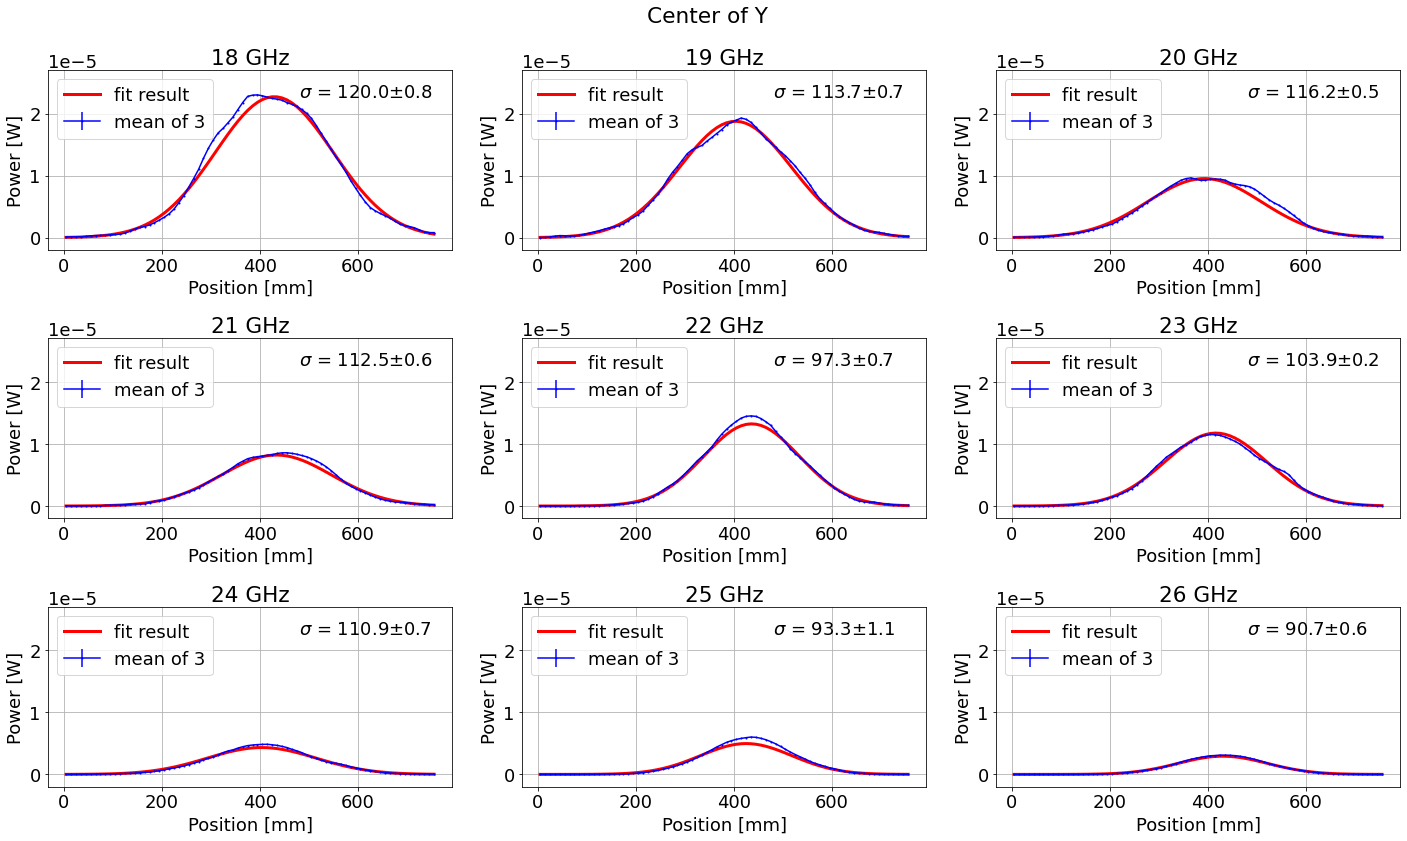

In [27]:
## Fit Power at Y-center
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle(f"Center of {xy_label_ycen}")
sigma_ycen = []
sigma_err_ycen = []
FWHMfit_ycen = []
FWHMfit_err_ycen = []
for i, _freq_str in enumerate(freqs_str):
    i_ax = (int)(i/3.)
    j_ax = i%3
    print(f'axis index = ({i_ax}, {j_ax})')
    _sigma, _sigma_err, _FWHM, _FWHM_err = plotSlice_fit(axes[i_ax][j_ax], _freq_str, xy=xy_label_ycen, xy_list=xy_list_ycen)
    sigma_ycen.append(_sigma)
    sigma_err_ycen.append(_sigma_err)
    FWHMfit_ycen.append(_FWHM)
    FWHMfit_err_ycen.append(_FWHM_err)
    pass
fig.tight_layout()
plt.savefig(f"{outdir_ycen}/powerfit.pdf")

## Fit Power at X-center

axis index = (0, 0)
sigma = 97.91 +- 1.51 mm
FWHMmm = 230.55 +- 3.56 mm
FWHM = 12.00 +- 0.19 deg.
FWHM for one antenna = 16.97 +- 0.27 deg.
axis index = (0, 1)
sigma = 98.71 +- 1.04 mm
FWHMmm = 232.44 +- 2.44 mm
FWHM = 12.09 +- 0.13 deg.
FWHM for one antenna = 17.10 +- 0.18 deg.
axis index = (0, 2)
sigma = 103.60 +- 1.20 mm
FWHMmm = 243.96 +- 2.82 mm
FWHM = 12.67 +- 0.15 deg.
FWHM for one antenna = 17.92 +- 0.21 deg.
axis index = (1, 0)
sigma = 82.21 +- 1.07 mm
FWHMmm = 193.59 +- 2.51 mm
FWHM = 10.12 +- 0.13 deg.
FWHM for one antenna = 14.31 +- 0.19 deg.
axis index = (1, 1)
sigma = 143.99 +- 6.78 mm
FWHMmm = 339.08 +- 15.97 mm
FWHM = 17.35 +- 0.84 deg.
FWHM for one antenna = 24.54 +- 1.19 deg.
axis index = (1, 2)
sigma = 94.44 +- 2.37 mm
FWHMmm = 222.40 +- 5.58 mm
FWHM = 11.58 +- 0.29 deg.
FWHM for one antenna = 16.38 +- 0.42 deg.
axis index = (2, 0)
sigma = 94.02 +- 1.76 mm
FWHMmm = 221.40 +- 4.14 mm
FWHM = 11.53 +- 0.22 deg.
FWHM for one antenna = 16.31 +- 0.31 deg.
axis index = (2, 

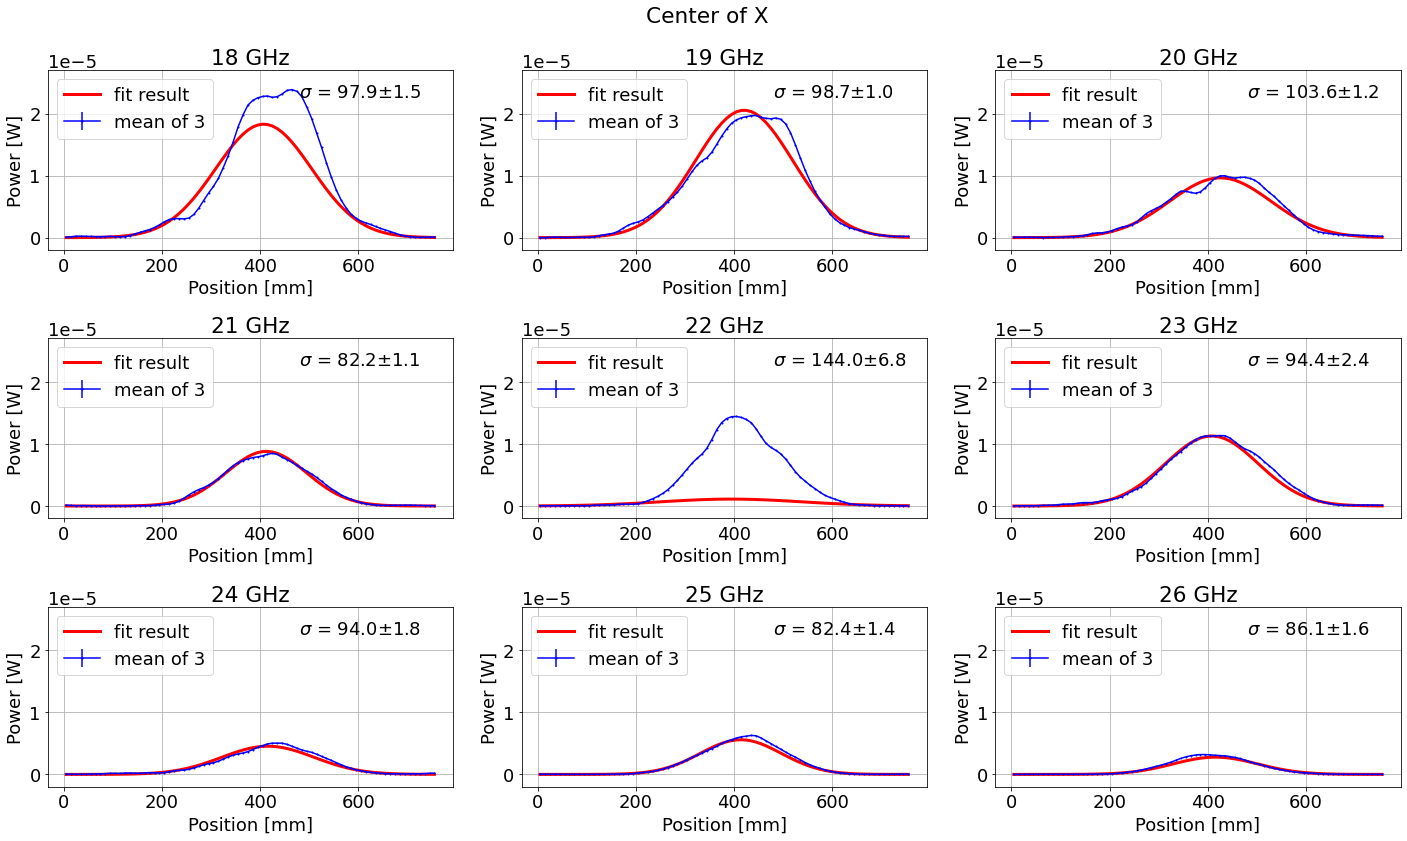

In [28]:
## Fit Power at X-center
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(3,3,figsize=(20,12), squeeze=False)
plt.suptitle(f"Center of {xy_label_xcen}")
sigma_xcen = []
sigma_err_xcen = []
FWHMfit_xcen = []
FWHMfit_err_xcen = []
for i, _freq_str in enumerate(freqs_str):
    i_ax = (int)(i/3.)
    j_ax = i%3
    print(f'axis index = ({i_ax}, {j_ax})')
    _sigma, _sigma_err, _FWHM, _FWHM_err = plotSlice_fit(axes[i_ax][j_ax], _freq_str, xy=xy_label_xcen, xy_list=xy_list_xcen)
    sigma_xcen.append(_sigma)
    sigma_err_xcen.append(_sigma_err)
    FWHMfit_xcen.append(_FWHM)
    FWHMfit_err_xcen.append(_FWHM_err)
    pass
fig.tight_layout()
plt.savefig(f"{outdir_xcen}/powerfit.pdf")

## Plot FWHM for all frequencies

In [29]:
# Calculate FWHM for all frequencies

## Retrieve FWHM (xsqrt(2) to consider one horn antenna)
fwhmfit_xcen = np.array(FWHMfit_xcen)*np.sqrt(2.)
fwhmfit_ycen = np.array(FWHMfit_ycen)*np.sqrt(2.)
fwhm_xcen = np.array(FWHM_xcen)*np.sqrt(2.)
fwhm_ycen = np.array(FWHM_ycen)*np.sqrt(2.)
fwhmfit_err_xcen = np.array(FWHMfit_err_xcen)*np.sqrt(2.)
fwhmfit_err_ycen = np.array(FWHMfit_err_ycen)*np.sqrt(2.)
fwhm_err_xcen = np.array(FWHM_err_xcen)*np.sqrt(2.)
fwhm_err_ycen = np.array(FWHM_err_ycen)*np.sqrt(2.)
## Calculate  weighted average of x-slice and y-slice
fwhm_weight_xcen = 1./fwhm_err_xcen
fwhm_weight_ycen = 1./fwhm_err_ycen
fwhm_weightave = ( fwhm_weight_xcen*fwhm_xcen + fwhm_weight_ycen*fwhm_ycen ) / (fwhm_weight_xcen + fwhm_weight_ycen)
fwhm_err_weightave = np.sqrt( np.power(fwhm_weight_xcen*fwhm_err_xcen, 2.) + np.power(fwhm_weight_ycen*fwhm_err_ycen, 2.) )/(fwhm_weight_xcen + fwhm_weight_ycen)

# Calculate difference from simulation
diff_xcen = abs(fwhm_xcen-FWHM_simulation)
diff_ycen = abs(fwhm_ycen-FWHM_simulation)
diff_weightave = abs(fwhm_weightave-FWHM_simulation)
diff_err_xcen = fwhm_err_xcen
diff_err_ycen = fwhm_err_ycen
diff_err_weightave = fwhm_err_weightave
# Calculate difference ratio from simulation
diffratio_xcen = diff_xcen/FWHM_simulation
diffratio_ycen = diff_ycen/FWHM_simulation
diffratio_weightave = diff_weightave/FWHM_simulation
diffratio_err_xcen = diff_err_xcen/FWHM_simulation
diffratio_err_ycen = diff_err_ycen/FWHM_simulation
diffratio_err_weightave = diff_err_weightave/FWHM_simulation

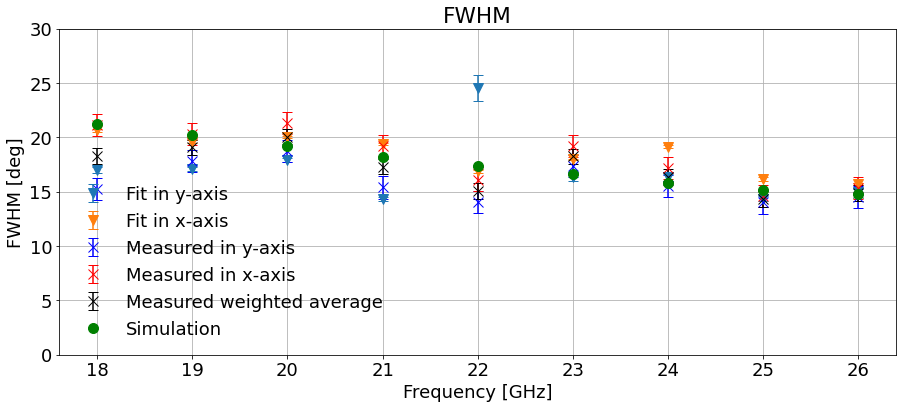

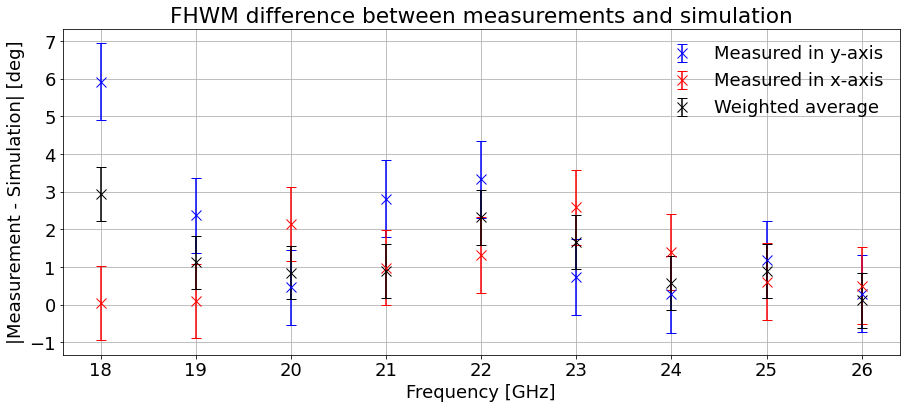

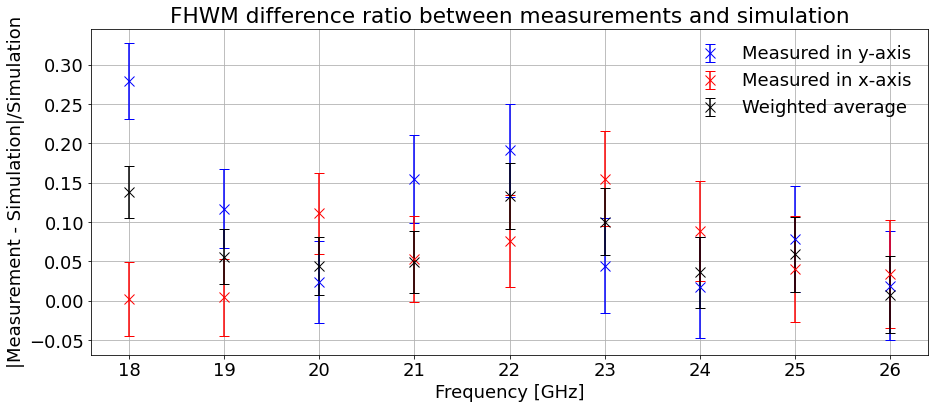

In [30]:
# FWHM plot
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
plt.errorbar(freqs, fwhmfit_xcen, yerr=fwhmfit_err_xcen, capsize=5, marker="v", markersize=10, color="tab:blue", label="Fit in y-axis", linestyle='')
plt.errorbar(freqs, fwhmfit_ycen, yerr=fwhmfit_err_ycen, capsize=5, marker="v", markersize=10, color="tab:orange", label="Fit in x-axis", linestyle='')
plt.errorbar(freqs, fwhm_xcen, yerr=fwhm_err_xcen, capsize=5, marker="x", markersize=10, color="blue", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, fwhm_ycen, yerr=fwhm_err_ycen, capsize=5, marker="x", markersize=10, color="red", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, fwhm_weightave, yerr=fwhm_err_weightave, capsize=5, marker="x", markersize=10, color="black", label="Measured weighted average", linestyle='')
plt.errorbar(freqs, FWHM_simulation, marker='o', markersize=10, color="green", label="Simulation", linestyle='')
plt.ylim([0, 30])
plt.grid()
plt.legend(frameon=False)
plt.title("FWHM")
plt.ylabel("FWHM [deg]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/{data_dir}_FWHM.pdf")


# Diff. plot
plt.figure(figsize=(15,6))
plt.errorbar(freqs, diff_xcen, yerr=diff_err_xcen, capsize=5, marker="x", markersize=10, color="blue", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, diff_ycen, yerr=diff_err_ycen, capsize=5, marker="x", markersize=10, color="red", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, diff_weightave, yerr=diff_err_weightave, capsize=5, marker="x", markersize=10, color="k", label="Weighted average", linestyle='')
plt.grid()
plt.legend(frameon=False)
plt.title("FHWM difference between measurements and simulation")
plt.ylabel("|Measurement - Simulation| [deg]")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/{data_dir}_FWHM_diff.pdf")

# Diff. ratio plot
plt.figure(figsize=(15,6))
plt.errorbar(freqs, diffratio_xcen, yerr=diffratio_err_xcen, capsize=5, marker="x", markersize=10, color="blue", label="Measured in y-axis", linestyle='')
plt.errorbar(freqs, diffratio_ycen, yerr=diffratio_err_ycen, capsize=5, marker="x", markersize=10, color="red", label="Measured in x-axis", linestyle='')
plt.errorbar(freqs, diffratio_weightave, yerr=diffratio_err_weightave, capsize=5, marker="x", markersize=10, color="k", label="Weighted average", linestyle='')
plt.grid()
plt.legend(frameon=False)
plt.title("FHWM difference ratio between measurements and simulation")
plt.ylabel("|Measurement - Simulation|/Simulation")
plt.xlabel("Frequency [GHz]")
plt.savefig(f"{outdir}/{data_dir}_FWHM_diffratio.pdf")

## Plot FWHM for all frequencies (For PAPER)

18 GHz: FWHM  = 20.89 deg
18 GHz: sigma = 8.87 deg
26.5 GHz: FWHM  = 13.95 deg
26.5 GHz: sigma = 5.92 deg
./plot/result_figure/xy_scan//2022-03-08_cycle_FWHM_for_paper_red.pdf


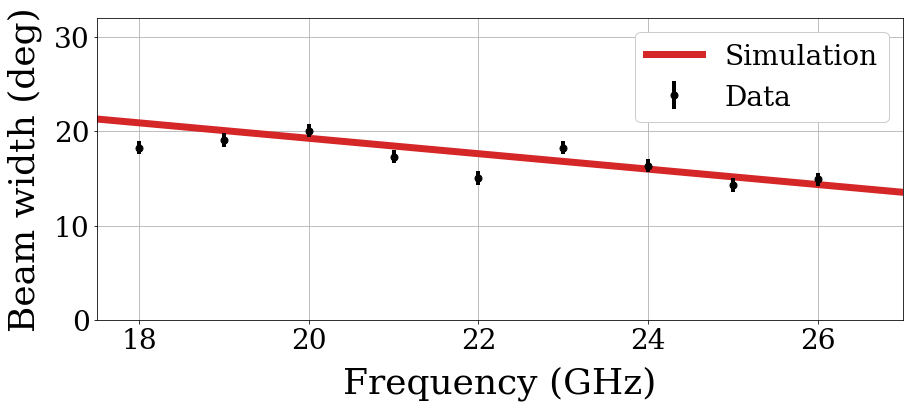

In [31]:
# polyfit to simulation
#plot_color='gray'
plot_color='red'
simulation_linear_model = np.polyfit(freqs,FWHM_simulation,1)
FWHM_simulation_fit = np.poly1d(simulation_linear_model)
print(f'18 GHz: FWHM  = {FWHM_simulation_fit(18.):.2f} deg')
print(f'18 GHz: sigma = {FWHM_to_sigma(FWHM_simulation_fit(18.)):.2f} deg')
print(f'26.5 GHz: FWHM  = {FWHM_simulation_fit(26.5):.2f} deg')
print(f'26.5 GHz: sigma = {FWHM_to_sigma(FWHM_simulation_fit(26.5)):.2f} deg')

fig = plt.figure(figsize=(14,6))
fig.tight_layout()
plt.rcParams["font.size"] = 28
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.family"] = 'serif'

freqs_add = [17.]+freqs+[27.]
#plt.errorbar(freqs, FWHM_simulation, marker='o', markersize=10, color="black", label="Simulation", linestyle='', alpha=0.5)
#plt.errorbar(freqs, fwhm_weightave, yerr=fwhm_err_weightave, label="Measured average", 
#             capsize=5, marker="x", markersize=12, color="black", linestyle='', elinewidth=2, ecolor='black')
#plt.plot(freqs_add, FWHM_simulation_fit(freqs_add), linestyle='-', linewidth=3, color='gray', label='Simulation', marker='o')
plt.plot(freqs_add, FWHM_simulation_fit(freqs_add), linestyle='-', linewidth=7, color=f'tab:{plot_color}', label='Simulation')
plt.errorbar(freqs, fwhm_weightave, yerr=fwhm_err_weightave, label="Data", 
             capsize=0, marker="o", markersize=7, color="black", linestyle='', linewidth=5, elinewidth=4, ecolor='black')

plt.xlim([17.5, 27])
plt.ylim([0, 32])
plt.grid()
plt.legend().get_frame().set_alpha(1.0)
plt.ylabel("Beam width (deg)", fontsize=36, labelpad=12)
plt.xlabel("Frequency (GHz)", fontsize=36, labelpad=12)
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.25, top=0.95)
figpath = f"{outdir}/{data_dir}_FWHM_for_paper_{plot_color}.pdf"
print(figpath)
plt.savefig(figpath)

In [309]:
## Max deviation
max_diffratio = max(diffratio_weightave)
print(f'Maximum deviation: {max_diffratio*100.:.3f} %')
## Max error
max_diffratio_err = max(diffratio_err_weightave)
print(f'Maximum error: {max_diffratio_err*100.:.3f} %')
## Std of deviations
std_diffratio = np.std(diffratio_weightave)
print(f'Std of deviations: {std_diffratio*100.:.3f} %')

Maximum deviation: 13.835 %
Maximum error: 4.877 %
Std of deviations: 4.222 %


# Calculate $\eta_{\mathrm{eff}}$ error

In [310]:
def integral_sphere(deg, y):
    rad = np.deg2rad(deg)
    return integrate.simps(y*np.abs(np.sin(rad)), rad)*np.pi # *pi comes from phi integral

# Get Omega_A from assumed a gaussian with a specific FWHM
# fhwm & theta should be deg.
def getOmega_from_FWHM(fwhm, theta, theta_cut=None):
    _theta = np.array(theta)
    _sigma = FWHM_to_sigma(fwhm)
    _gauss = gauss_1d(theta, h=1., m=0., s=_sigma)
    if theta_cut is not None:
        _cut = np.where(np.abs(_theta) < theta_cut)
        _gauss = _gauss[_cut]
        _theta = _theta[_cut]
        pass
    return integral_sphere(_theta, _gauss), _sigma, _gauss, _theta

def Omega_to_Aeff(Omega_A, freq):
    return np.power(freq, 2.)/Omega_A

phi_antenna = 59.3 # mm
A_antenna = np.pi * (phi_antenna/2*1e-3)**2 # m^2

theta_deg = np.linspace(-180., 180., 2000)

In [317]:
def calculate_Aeff_error(freqs=freqs, FWHMs=FWHM_simulation, FWHM_errratio=max_diffratio):
    Omega_A_sim = []
    Omega_A_sim_up = []
    Omega_A_sim_down = []

    for i, freq in enumerate(freqs):
        # deg.
        _fwhm = FWHMs[i]
        _fwhm_up   = FWHMs[i] * (1. + FWHM_errratio)
        _fwhm_down = FWHMs[i] * (1. - FWHM_errratio)
        _Omega, _sigma, _gauss, _theta = getOmega_from_FWHM(_fwhm, theta_deg) # theta should be deg
        _Omega_up, _sigma_up, _gauss_up, _theta_up = getOmega_from_FWHM(_fwhm_up, theta_deg) # theta should be deg
        _Omega_down, _sigma_down, _gauss_down, _theta_down = getOmega_from_FWHM(_fwhm_down, theta_deg) # theta should be deg
        Omega_A_sim.append(_Omega)
        Omega_A_sim_up.append(_Omega_up)
        Omega_A_sim_down.append(_Omega_down)
        print(f'Omega_A    = {_Omega:.2f}')
        print(f'Omega_A up   = {_Omega_up:.2f}   ({(_Omega_up  /_Omega-1.)*100.:.2f} %)')
        print(f'Omega_A down = {_Omega_down:.2f} ({(1.-_Omega_down/_Omega)*100.:.2f} %)')
        # Plot for check
        if i == 0:
            fig = plt.figure(figsize=(14,6))
            fig.tight_layout()
            plt.plot(theta_deg, _gauss, c='black', label='Nominal')
            plt.plot(theta_deg, _gauss_up, c='red', label='Up')
            plt.plot(theta_deg, _gauss_down, c='blue', label='Down')
            plt.legend()
            plt.xlim(-60.,60.)
            pass
        pass
    Omega_A_sim = np.array(Omega_A_sim)
    Omega_A_sim_up = np.array(Omega_A_sim_up)
    Omega_A_sim_down = np.array(Omega_A_sim_down)
        
    from scipy import constants
    c = constants.c
    print(f'Light of speed c = {c:e} m/sec')
    wavelengths = c/(np.array(freqs)*1.e+9) # [m]
    print(f'Wavelength = {wavelengths*1.e3} mm')
    A_eff_sim = Omega_to_Aeff(Omega_A_sim, freqs)
    A_eff_sim_up = Omega_to_Aeff(Omega_A_sim_up, freqs)
    A_eff_sim_down = Omega_to_Aeff(Omega_A_sim_down, freqs)
    A_eff_sim_errratio_ave = abs(A_eff_sim_up-A_eff_sim_down)/2./A_eff_sim
    print(f'Aeff systematic error = {A_eff_sim_errratio_ave*100.} %')
    print(f'--> Averenged = {np.mean(A_eff_sim_errratio_ave)*100.:.2f} %')
    eta_sim = A_eff_sim/A_antenna
    eta_sim_up = A_eff_sim_up/A_antenna
    eta_sim_down = A_eff_sim_down/A_antenna
    
    return

## Calculate $\eta_{\mathrm{eff}}$ error from maximum diff. of $\sigma_{1/2}$

Omega_A    = 0.15
Omega_A up   = 0.20   (29.27 %)
Omega_A down = 0.11 (25.60 %)
Omega_A    = 0.14
Omega_A up   = 0.18   (29.30 %)
Omega_A down = 0.10 (25.61 %)
Omega_A    = 0.13
Omega_A up   = 0.16   (29.32 %)
Omega_A down = 0.09 (25.63 %)
Omega_A    = 0.11
Omega_A up   = 0.15   (29.35 %)
Omega_A down = 0.08 (25.64 %)
Omega_A    = 0.10
Omega_A up   = 0.13   (29.37 %)
Omega_A down = 0.08 (25.65 %)
Omega_A    = 0.09
Omega_A up   = 0.12   (29.39 %)
Omega_A down = 0.07 (25.66 %)
Omega_A    = 0.09
Omega_A up   = 0.11   (29.41 %)
Omega_A down = 0.06 (25.67 %)
Omega_A    = 0.08
Omega_A up   = 0.10   (29.42 %)
Omega_A down = 0.06 (25.67 %)
Omega_A    = 0.08
Omega_A up   = 0.10   (29.43 %)
Omega_A down = 0.06 (25.68 %)
Light of speed c = 2.997925e+08 m/sec
Wavelength = [16.65513656 15.77855042 14.9896229  14.27583133 13.62692991 13.0344547
 12.49135242 11.99169832 11.53047915] mm
Aeff systematic error = [28.52317704 28.54485143 28.565474   28.58504181 28.59993431 28.61414741
 28.62767858 28.637

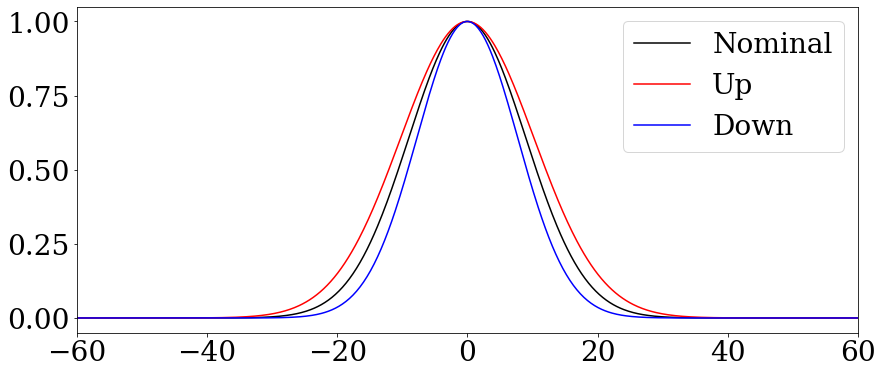

In [318]:
calculate_Aeff_error(freqs=freqs, FWHMs=FWHM_simulation, FWHM_errratio=max_diffratio)

## Calculate $\eta_{\mathrm{eff}}$ error from std. diff. of $\sigma_{1/2}$

Omega_A    = 0.15
Omega_A up   = 0.17   (8.55 %)
Omega_A down = 0.14 (8.20 %)
Omega_A    = 0.14
Omega_A up   = 0.15   (8.55 %)
Omega_A down = 0.13 (8.21 %)
Omega_A    = 0.13
Omega_A up   = 0.14   (8.56 %)
Omega_A down = 0.12 (8.21 %)
Omega_A    = 0.11
Omega_A up   = 0.12   (8.57 %)
Omega_A down = 0.10 (8.22 %)
Omega_A    = 0.10
Omega_A up   = 0.11   (8.57 %)
Omega_A down = 0.10 (8.22 %)
Omega_A    = 0.09
Omega_A up   = 0.10   (8.57 %)
Omega_A down = 0.09 (8.23 %)
Omega_A    = 0.09
Omega_A up   = 0.09   (8.58 %)
Omega_A down = 0.08 (8.23 %)
Omega_A    = 0.08
Omega_A up   = 0.09   (8.58 %)
Omega_A down = 0.07 (8.23 %)
Omega_A    = 0.08
Omega_A up   = 0.08   (8.58 %)
Omega_A down = 0.07 (8.24 %)
Light of speed c = 2.997925e+08 m/sec
Wavelength = [16.65513656 15.77855042 14.9896229  14.27583133 13.62692991 13.0344547
 12.49135242 11.99169832 11.53047915] mm
Aeff systematic error = [8.4045401  8.41092951 8.41700906 8.42277795 8.42716876 8.43135959
 8.43534974 8.43821017 8.44005396] %
--> Av

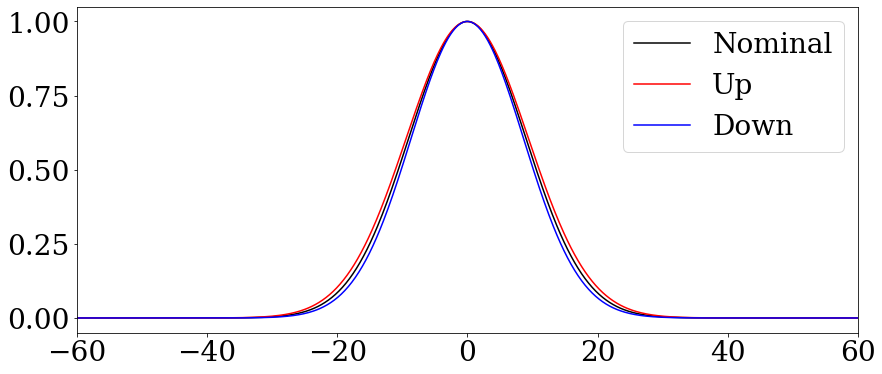

In [319]:
calculate_Aeff_error(freqs=freqs, FWHMs=FWHM_simulation, FWHM_errratio=std_diffratio)

# Calcuate $\eta_{\mathrm{window}}$ error

In [320]:
L = 1.0865 # [m] the length between anntena and window
radius = 0.105 # [m] the radius of window
theta_win = np.degrees(np.arctan(radius/L)) # [deg] 
print(f'theta_window = {theta_win} deg')

theta_window = 5.519956106054329 deg


Omega_win    = 0.03
Omega_win up   = 0.03   (2.09 %)
Omega_win down = 0.03 (3.06 %)
Omega_win    = 0.03
Omega_win up   = 0.03   (2.29 %)
Omega_win down = 0.03 (3.35 %)
Omega_win    = 0.03
Omega_win up   = 0.03   (2.53 %)
Omega_win down = 0.02 (3.69 %)
Omega_win    = 0.03
Omega_win up   = 0.03   (2.81 %)
Omega_win down = 0.02 (4.08 %)
Omega_win    = 0.03
Omega_win up   = 0.03   (3.07 %)
Omega_win down = 0.02 (4.43 %)
Omega_win    = 0.02
Omega_win up   = 0.03   (3.36 %)
Omega_win down = 0.02 (4.83 %)
Omega_win    = 0.02
Omega_win up   = 0.03   (3.70 %)
Omega_win down = 0.02 (5.29 %)
Omega_win    = 0.02
Omega_win up   = 0.03   (3.99 %)
Omega_win down = 0.02 (5.67 %)
Omega_win    = 0.02
Omega_win up   = 0.02   (4.20 %)
Omega_win down = 0.02 (5.94 %)
Light of speed c = 2.997925e+08 m/sec
Wavelength = [16.65513656 15.77855042 14.9896229  14.27583133 13.62692991 13.0344547
 12.49135242 11.99169832 11.53047915] mm
Aeff_win systematic error = [2.60147317 2.85704147 3.15161649 3.4933957  3.80770

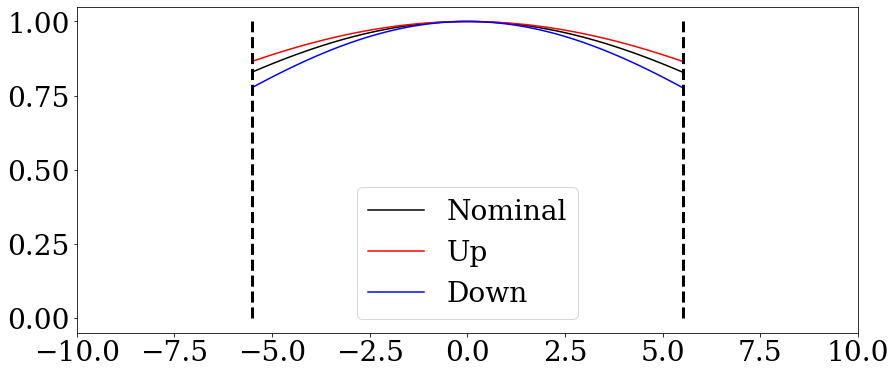

In [298]:
Omega_win = []
Omega_win_up = []
Omega_win_down = []

for i, freq in enumerate(freqs):
    # deg.
    _fwhm = FWHM_simulation[i]
    _fwhm_up   = FWHM_simulation[i] * (1. + max_diffratio)
    _fwhm_down = FWHM_simulation[i] * (1. - max_diffratio)
    _Omega, _sigma, _gauss, _theta = getOmega_from_FWHM(_fwhm, theta_deg, theta_cut=theta_win) # theta should be deg
    _Omega_up, _sigma_up, _gauss_up, _theta_up = getOmega_from_FWHM(_fwhm_up, theta_deg, theta_cut=theta_win) # theta should be deg
    _Omega_down, _sigma_down, _gauss_down, _theta_down = getOmega_from_FWHM(_fwhm_down, theta_deg, theta_cut=theta_win) # theta should be deg
    Omega_win.append(_Omega)
    Omega_win_up.append(_Omega_up)
    Omega_win_down.append(_Omega_down)
    print(f'Omega_win    = {_Omega:.2f}')
    print(f'Omega_win up   = {_Omega_up:.2f}   ({(_Omega_up  /_Omega-1.)*100.:.2f} %)')
    print(f'Omega_win down = {_Omega_down:.2f} ({(1.-_Omega_down/_Omega)*100.:.2f} %)')
    # Plot for check
    if i==0:
        fig = plt.figure(figsize=(14,6))
        fig.tight_layout()
        plt.plot(_theta, _gauss, c='black', label='Nominal')
        plt.plot(_theta, _gauss_up, c='red', label='Up')
        plt.plot(_theta, _gauss_down, c='blue', label='Down')
        plt.plot([-theta_win, -theta_win], [0., 1.], linestyle='--', linewidth=3, c='black')
        plt.plot([theta_win, theta_win], [0., 1.], linestyle='--', linewidth=3, c='black')
        plt.legend()
        plt.xlim(-10.,10.)
        pass
    pass
Omega_win = np.array(Omega_win)
Omega_win_up = np.array(Omega_win_up)
Omega_win_down = np.array(Omega_win_down)
        
from scipy import constants
c = constants.c
print(f'Light of speed c = {c:e} m/sec')
wavelengths = c/(np.array(freqs)*1.e+9) # [m]
print(f'Wavelength = {wavelengths*1.e3} mm')
A_eff_win = Omega_to_Aeff(Omega_win, freqs)
A_eff_win_up = Omega_to_Aeff(Omega_win_up, freqs)
A_eff_win_down = Omega_to_Aeff(Omega_win_down, freqs)
A_eff_win_errratio_ave = abs(A_eff_win_up-A_eff_win_down)/2./A_eff_win
print(f'Aeff_win systematic error = {A_eff_win_errratio_ave*100.} %')
print(f'--> Averenged = {np.mean(A_eff_win_errratio_ave)*100.:.2f} %')
eta_win = A_eff_win/A_antenna
eta_win_up = A_eff_win_up/A_antenna
eta_win_down = A_eff_win_down/A_antenna
eta_win_errratio_ave = abs(eta_win_up-eta_win_down)/2./eta_win
print(f'eta_win systematic error = {eta_win_errratio_ave*100.} %')
print(f'--> Averenged = {np.mean(eta_win_errratio_ave)*100.:.2f} %')